AD (Test)


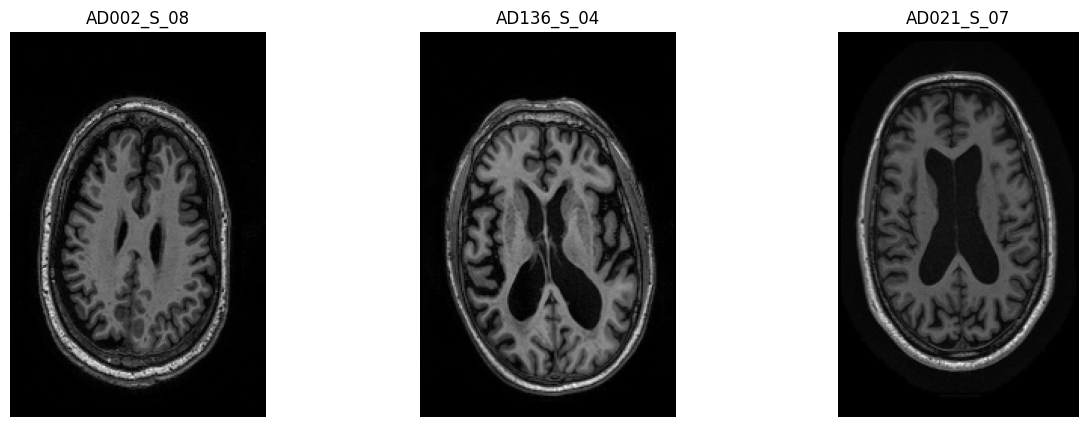

CN (Test)


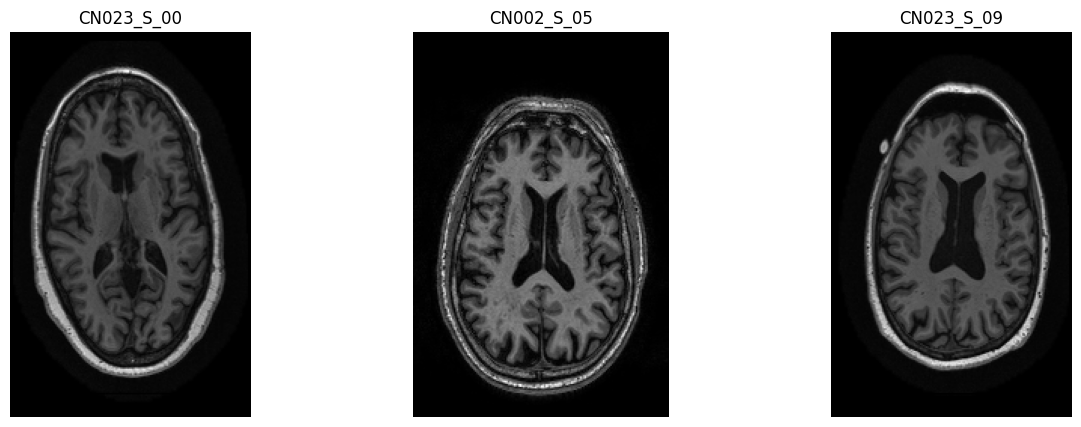

MCI (Test)


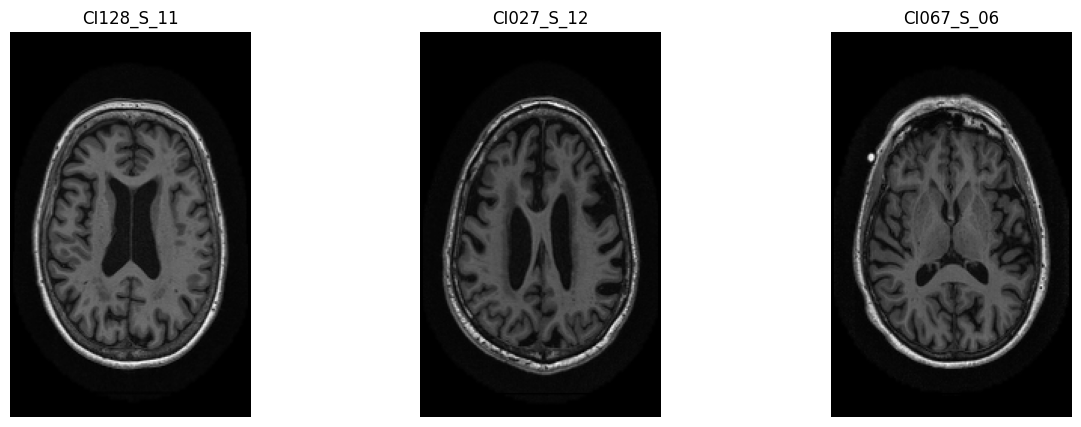

AD (Train)


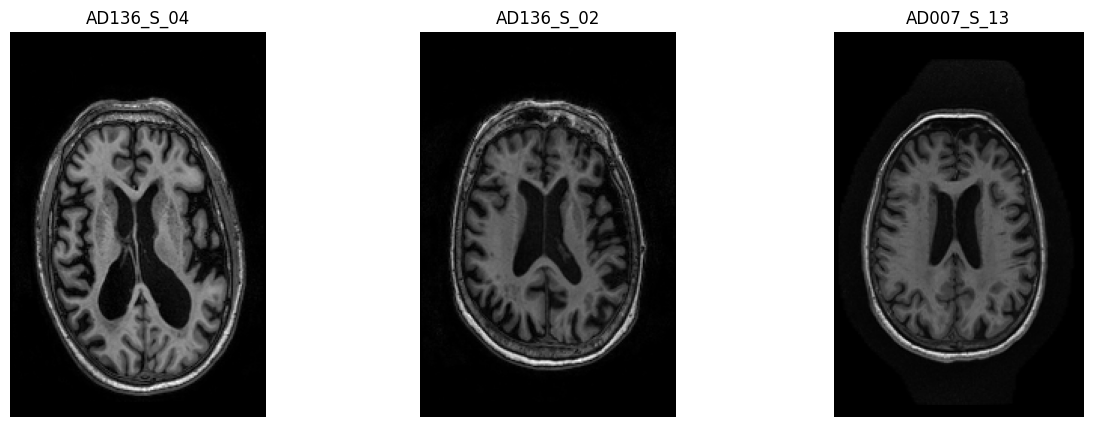

CN (Train)


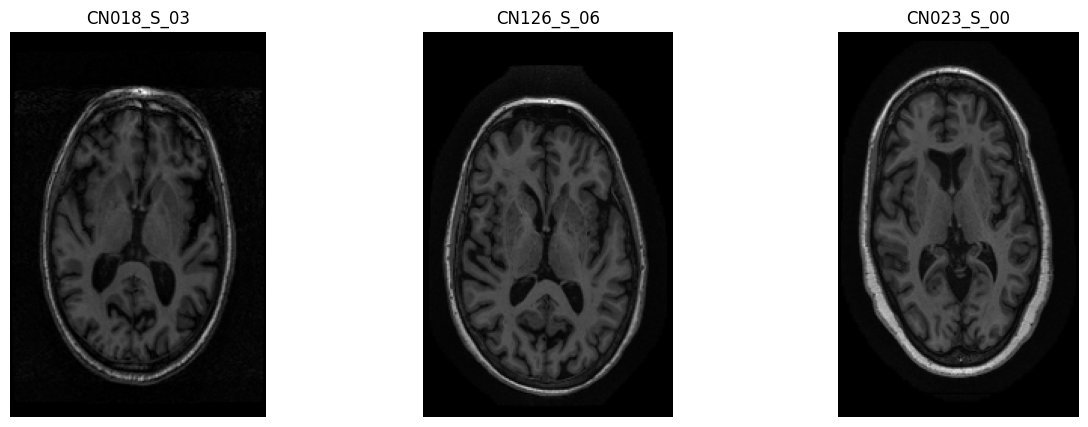

MCI (Train)


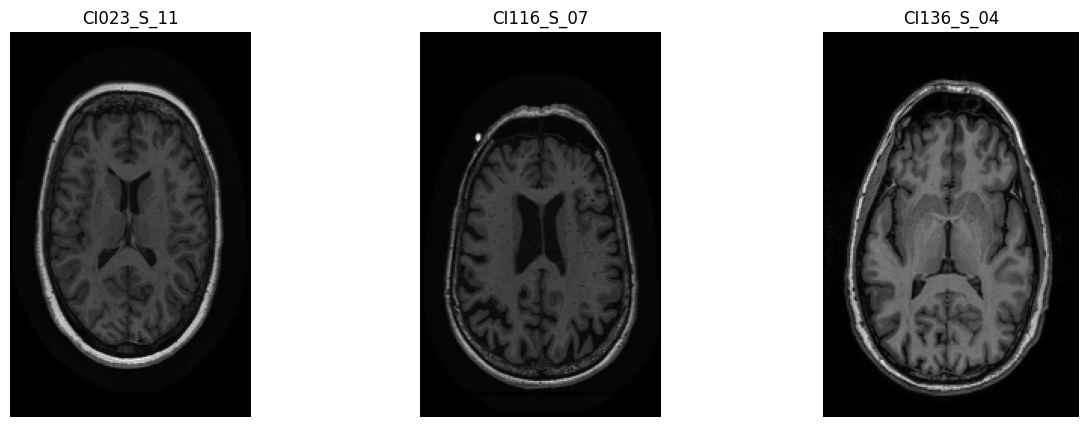

In [1]:
import os
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np

# Keep your original directories and subfolders
test_dir = "/kaggle/input/alzheimer-disease/test-20251010T094612Z-1-001/test"
train_dir = "/kaggle/input/alzheimer-disease/train-20251010T183510Z-1-001/train"
subfolders = ["AD", "CN", "MCI"]

# Function to show 3 images from each subfolder (unchanged signature)
def show_images_from_dir(path, n=3):
    # List only image files (same behavior; expanded to be robust if needed)
    files = [f for f in os.listdir(path) if f.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.tif', '.tiff'))]
    files = files[:n]  # Take only the first n images

    plt.figure(figsize=(15, 5))
    for i, file in enumerate(files):
        img_path = os.path.join(path, file)

        # Open with PIL
        img = Image.open(img_path)

        # --- CRITICAL FIX ---
        # Force grayscale to ensure single-channel display (no colorization)
        # Even if the source is already grayscale, this guarantees mode 'L'
        img = img.convert('L')

        # Convert to numpy for safe imshow with explicit bounds
        arr = np.asarray(img)

        # Display as true grayscale with fixed intensity bounds
        plt.subplot(1, len(files), i + 1)
        plt.imshow(arr, cmap='gray', vmin=0, vmax=255)
        plt.axis("off")
        plt.title(file[:10])

    plt.show()


# Show images for Test set
for subfolder in subfolders:
    print(f"{subfolder} (Test)")
    show_images_from_dir(os.path.join(test_dir, subfolder))

# Show images for Train set
for subfolder in subfolders:
    print(f"{subfolder} (Train)")
    show_images_from_dir(os.path.join(train_dir, subfolder))

=== 2D MRI Preprocessing (GPU homomorphic + 2D skull-strip): TEST ===
Device for homomorphic filtering: cuda


/tmp/ipykernel_19/2569239085.py:107: DeprecationWarning: 'mode' parameter is deprecated and will be removed in Pillow 13 (2026-10-15)
  Image.fromarray(arr_u8, mode="L").save(path)


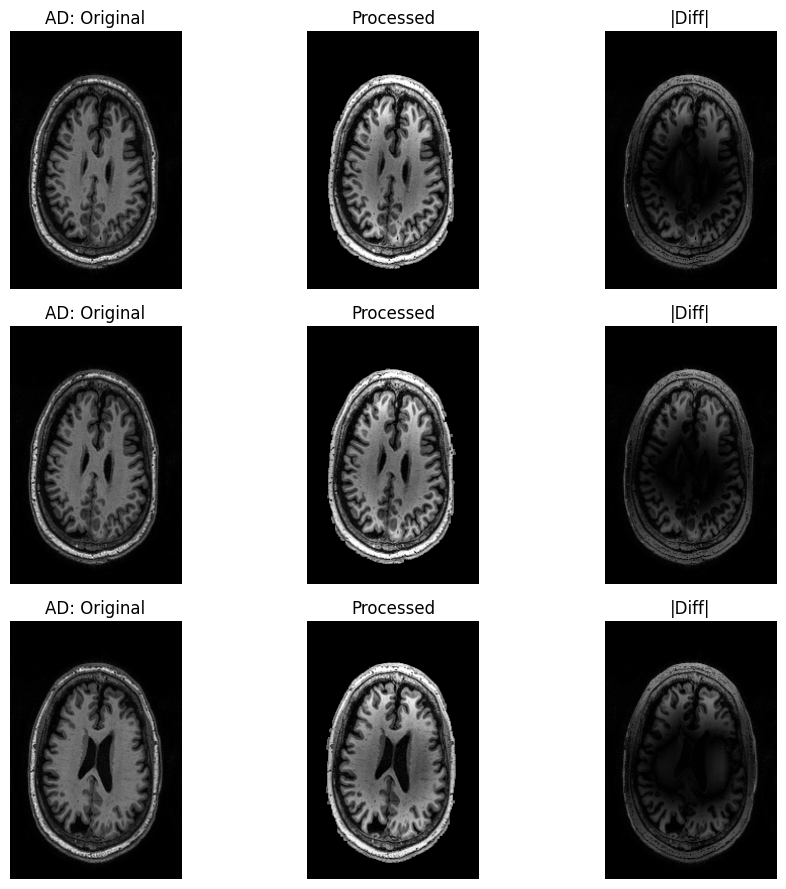

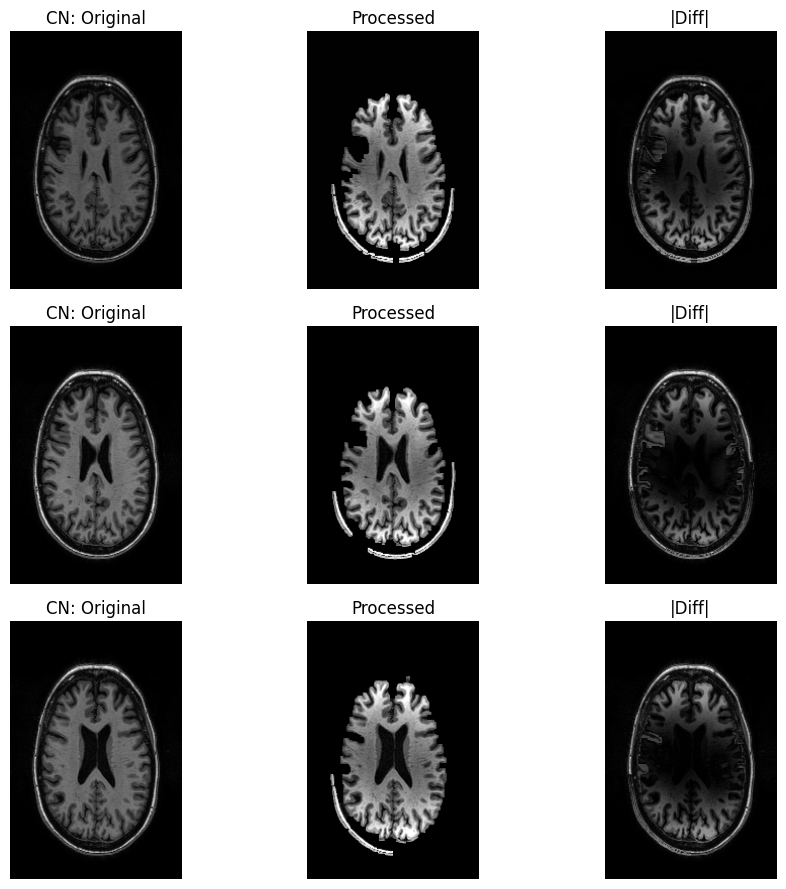

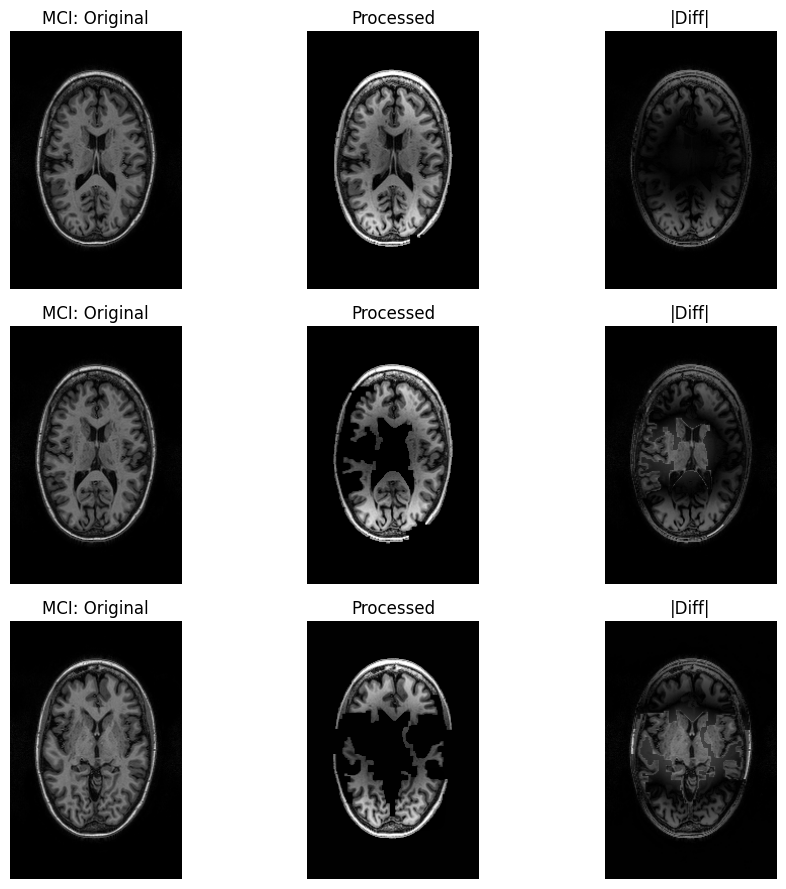

=== 2D MRI Preprocessing (GPU homomorphic + 2D skull-strip): TRAIN ===
Device for homomorphic filtering: cuda


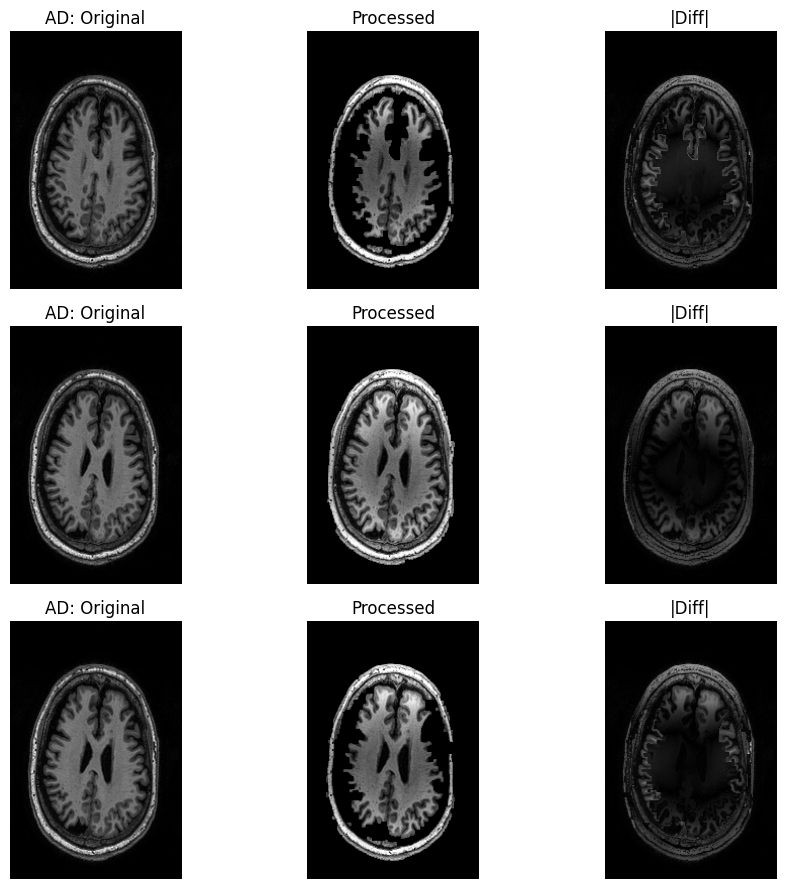

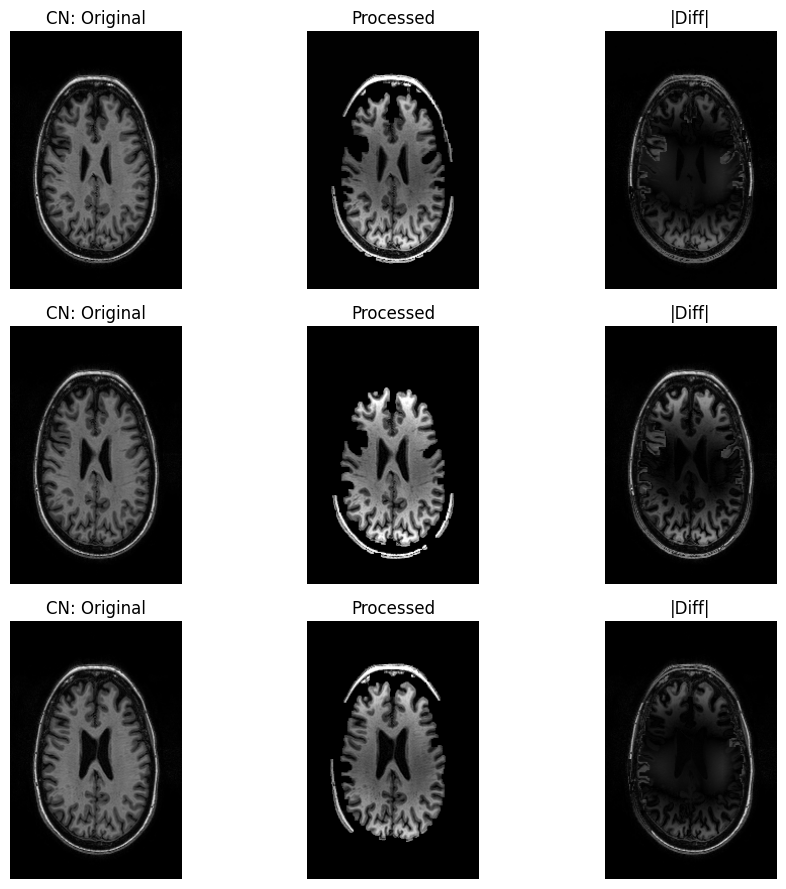

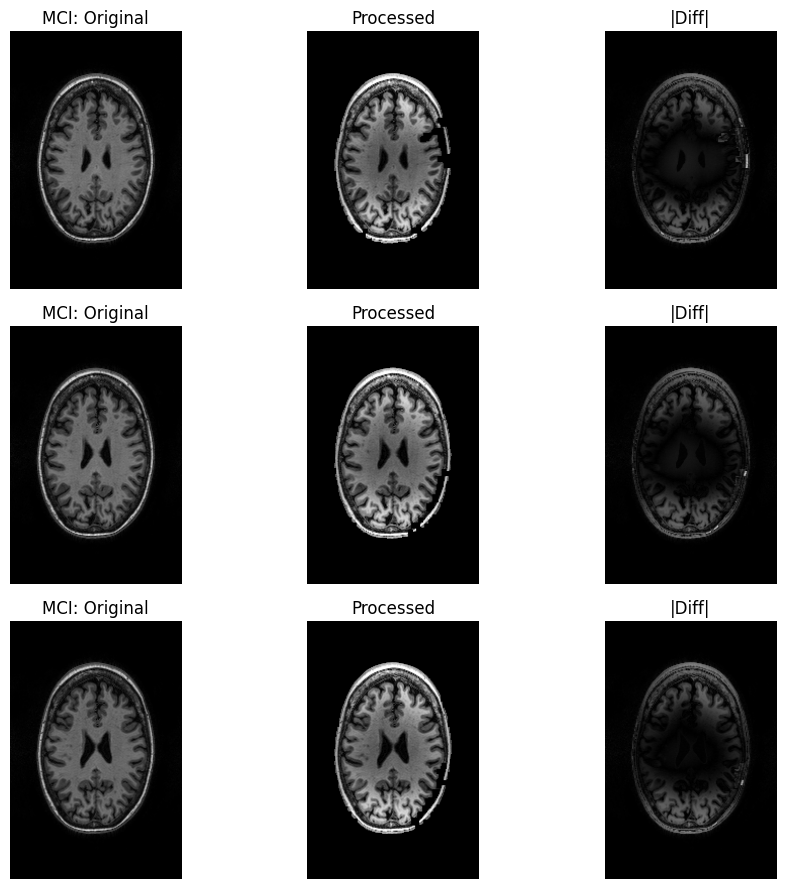

Preprocessed images saved to:
  • Test : /kaggle/working/alzheimer-preprocessed/test
  • Train: /kaggle/working/alzheimer-preprocessed/train
Summary TEST : AD: 225 ok / 0 skipped, CN: 288 ok / 0 skipped, MCI: 518 ok / 0 skipped
Summary TRAIN: AD: 899 ok / 0 skipped, CN: 1152 ok / 0 skipped, MCI: 2072 ok / 0 skipped


In [2]:
import os
import sys
import numpy as np
from PIL import Image, UnidentifiedImageError
import matplotlib.pyplot as plt

# SciPy for morphology / connected components (Kaggle preinstalled)
from scipy.ndimage import (
    gaussian_filter,
    binary_opening,
    binary_closing,
    binary_fill_holes,
    label
)

# Try skimage for CLAHE; fall back gracefully if missing
try:
    from skimage.exposure import equalize_adapthist
    _HAS_SKIMAGE = True
except Exception:
    _HAS_SKIMAGE = False


# GPU via PyTorch (for homomorphic filtering)

def _ensure(pkg):
    import importlib
    try:
        importlib.import_module(pkg)
    except Exception:
        import subprocess
        subprocess.check_call([sys.executable, "-m", "pip", "install", pkg, "--quiet"])

_ensure("torch")
import torch
import torch.nn.functional as F

def torch_device():
    return torch.device("cuda" if torch.cuda.is_available() else "cpu")

def gaussian_kernel_2d(sigma: float, radius_factor: float = 3.0, device=None, dtype=torch.float32):
    """Create a 2D Gaussian kernel tensor for conv2d (normalized)."""
    device = device or torch_device()
    rad = max(1, int(radius_factor * sigma))
    xs = torch.arange(-rad, rad + 1, device=device, dtype=dtype)
    g1 = torch.exp(-0.5 * (xs / sigma) ** 2)
    g1 = g1 / g1.sum()
    g2 = g1[:, None] @ g1[None, :]
    g2 = g2 / g2.sum()
    return g2  # (K, K)

def homomorphic_filter_gpu_u8(arr_u8: np.ndarray, sigma: float = 50.0) -> np.ndarray:
    """
    GPU homomorphic filtering (log → low-pass via conv2d → exp → robust rescale).
    Input uint8 [0..255], output uint8 [0..255].
    """
    dev = torch_device()
    # [B=1,C=1,H,W] float32
    img = torch.from_numpy(arr_u8.astype(np.float32)).to(dev) + 1.0  # avoid log(0)
    img = img[None, None, :, :]  # NCHW
    loga = torch.log(img)
    # 2D Gaussian low-pass via conv2d (reflect padding to avoid border artifacts)
    k = gaussian_kernel_2d(sigma=sigma, device=dev)
    k = k[None, None, :, :]  # (out_c,in_c,H,W)
    pad = k.shape[-1] // 2
    low = F.conv2d(F.pad(loga, (pad, pad, pad, pad), mode="reflect"), k)
    high = loga - low
    corr = torch.exp(high) - 1.0  # back to linear domain

    # Robust percentile rescale to uint8
    a = corr.squeeze(0).squeeze(0)  # HxW
    # Compute percentiles on CPU for simplicity
    a_np = a.detach().cpu().numpy().astype(np.float32)
    lo, hi = np.percentile(a_np, [0.5, 99.5])
    if hi - lo < 1e-6:
        a_np = (a_np - a_np.min()) / (a_np.ptp() + 1e-8)
    else:
        a_np = np.clip((a_np - lo) / (hi - lo), 0.0, 1.0)
    out_u8 = (a_np * 255.0 + 0.5).astype(np.uint8)
    return out_u8


test_dir = "/kaggle/input/alzheimer-disease/test-20251010T094612Z-1-001/test"
train_dir = "/kaggle/input/alzheimer-disease/train-20251010T183510Z-1-001/train"
subfolders = ["AD", "CN", "MCI"]


# Output (mirrors the structure)

preprocessed_root = "/kaggle/working/alzheimer-preprocessed"
preprocessed_test = os.path.join(preprocessed_root, "test")
preprocessed_train = os.path.join(preprocessed_root, "train")

IMG_EXT = (".png", ".jpg", ".jpeg", ".bmp", ".tif", ".tiff")

def ensure_dir(p: str):
    os.makedirs(p, exist_ok=True)


# Utilities

def load_gray(path: str) -> np.ndarray:
    """Load as uint8 grayscale [0..255]."""
    return np.asarray(Image.open(path).convert("L"), dtype=np.uint8)

def save_gray(arr_u8: np.ndarray, path: str):
    Image.fromarray(arr_u8, mode="L").save(path)

def percentile_rescale_u8(arr: np.ndarray, p_low=1.0, p_high=99.0) -> np.ndarray:
    """Robust contrast stretching to uint8."""
    a = arr.astype(np.float32)
    lo, hi = np.percentile(a, [p_low, p_high])
    if hi - lo < 1e-6:
        a = (a - a.min()) / (a.ptp() + 1e-8)
    else:
        a = np.clip((a - lo) / (hi - lo), 0.0, 1.0)
    return (a * 255.0 + 0.5).astype(np.uint8)

def otsu_threshold_u8(arr_u8: np.ndarray) -> int:
    """Pure NumPy Otsu threshold (returns 0..255)."""
    hist = np.bincount(arr_u8.ravel(), minlength=256).astype(np.float64)
    prob = hist / (arr_u8.size + 1e-12)
    omega = np.cumsum(prob)
    mu = np.cumsum(prob * np.arange(256))
    mu_t = mu[-1]
    sigma_b2 = (mu_t * omega - mu) ** 2 / (omega * (1 - omega) + 1e-12)
    sigma_b2[~np.isfinite(sigma_b2)] = 0.0
    return int(np.argmax(sigma_b2))

def largest_cc(mask: np.ndarray) -> np.ndarray:
    """Keep only largest connected component of a binary mask."""
    lbl, n = label(mask.astype(np.uint8))
    if n <= 1:
        return mask.astype(bool)
    counts = np.bincount(lbl.ravel())
    counts[0] = 0  # background
    keep = counts.argmax()
    return (lbl == keep)

def clahe_u8(arr_u8: np.ndarray) -> np.ndarray:
    """CLAHE if skimage is available; otherwise identity."""
    if _HAS_SKIMAGE:
        arr01 = arr_u8.astype(np.float32) / 255.0
        out01 = equalize_adapthist(arr01, clip_limit=0.01)
        return (np.clip(out01, 0.0, 1.0) * 255.0 + 0.5).astype(np.uint8)
    else:
        return arr_u8


# Core: one-image preprocessing

def preprocess_single_image(
    arr_u8: np.ndarray,
    do_skull_strip: bool = True,
    sigma_homomorphic: float = 50.0,
    min_area: int = 500
):
    """
    Steps:
      1) Robust pre-stretch (percentile)
      2) GPU homomorphic filter (PyTorch)
      3) (Optional) 2D skull/background stripping via Otsu + morphology + LCC + hole fill
      4) Gentle CLAHE (if available), else percentile rescale
    Returns processed uint8 image, plus an optional mask (uint8).
    """
    # 1) Robust stretch
    a1 = percentile_rescale_u8(arr_u8, 1.0, 99.0)

    # 2) Homomorphic filtering on GPU
    a2 = homomorphic_filter_gpu_u8(a1, sigma=sigma_homomorphic)

    brain_mask = None
    if do_skull_strip:
        # 3) Otsu thresholding (foreground bright)
        th = otsu_threshold_u8(a2)
        mask = (a2 >= th).astype(np.uint8)

        # Morphological clean-up
        mask = binary_opening(mask, structure=np.ones((3,3), dtype=np.uint8))
        mask = binary_closing(mask, structure=np.ones((5,5), dtype=np.uint8))
        mask = binary_fill_holes(mask)
        mask = largest_cc(mask)

        # Remove tiny masks (safety)
        if mask.sum() < min_area:
            mask = np.ones_like(mask, dtype=bool)  # fallback: keep as-is

        a3 = (a2 * mask).astype(np.uint8)
        brain_mask = (mask.astype(np.uint8) * 255)
    else:
        a3 = a2

    # 4) CLAHE or robust stretch
    a4 = clahe_u8(a3)
    a4 = percentile_rescale_u8(a4, 0.5, 99.5)

    return a4, brain_mask


# Dataset-level processing & visualization

def preprocess_dataset(src_root: str, dst_root: str, n_preview: int = 3, do_skull_strip=True):
    """
    Applies the pipeline to all images under src_root/{AD|CN|MCI}
    and writes to dst_root/{AD|CN|MCI}. Silent on per-file issues.
    """
    ensure_dir(dst_root)
    summary = {}

    # Report GPU/CPU
    dev = torch_device()
    print(f"Device for homomorphic filtering: {dev}")

    for cls in subfolders:
        src_cls = os.path.join(src_root, cls)
        dst_cls = os.path.join(dst_root, cls)
        ensure_dir(dst_cls)

        processed = skipped = 0
        if not os.path.isdir(src_cls):
            summary[cls] = (0, 0)
            continue

        files = sorted([f for f in os.listdir(src_cls) if f.lower().endswith(IMG_EXT)])

        # Process & save
        for fname in files:
            spath = os.path.join(src_cls, fname)
            dpath = os.path.join(dst_cls, fname)
            try:
                arr = load_gray(spath)
                proc, _ = preprocess_single_image(arr, do_skull_strip=do_skull_strip)
                save_gray(proc, dpath)
                processed += 1
            except (UnidentifiedImageError, OSError, RuntimeError, ValueError):
                skipped += 1
                continue

        summary[cls] = (processed, skipped)

        # Preview few examples
        preview = files[:n_preview]
        if preview:
            fig, axs = plt.subplots(len(preview), 3, figsize=(10, 3*len(preview)))
            if len(preview) == 1:
                axs = np.expand_dims(axs, 0)
            for i, fname in enumerate(preview):
                sp = os.path.join(src_cls, fname)
                dp = os.path.join(dst_cls, fname)
                try:
                    orig = load_gray(sp)
                    proc = load_gray(dp)
                    diff = np.abs(proc.astype(np.int16) - orig.astype(np.int16)).astype(np.uint8)

                    axs[i, 0].imshow(orig, cmap="gray", vmin=0, vmax=255); axs[i,0].axis("off"); axs[i,0].set_title(f"{cls}: Original")
                    axs[i, 1].imshow(proc, cmap="gray", vmin=0, vmax=255); axs[i,1].axis("off"); axs[i,1].set_title("Processed")
                    axs[i, 2].imshow(diff, cmap="gray", vmin=0, vmax=255); axs[i,2].axis("off"); axs[i,2].set_title("|Diff|")
                except Exception:
                    continue
            plt.tight_layout()
            plt.show()

    return summary


print("=== 2D MRI Preprocessing (GPU homomorphic + 2D skull-strip): TEST ===")
sum_test = preprocess_dataset(test_dir, preprocessed_test, n_preview=3, do_skull_strip=True)

print("=== 2D MRI Preprocessing (GPU homomorphic + 2D skull-strip): TRAIN ===")
sum_train = preprocess_dataset(train_dir, preprocessed_train, n_preview=3, do_skull_strip=True)

def _fmt(s): return ", ".join([f"{k}: {v[0]} ok / {v[1]} skipped" for k, v in s.items()])
print("Preprocessed images saved to:")
print(f"  • Test : {preprocessed_test}")
print(f"  • Train: {preprocessed_train}")
print("Summary TEST :", _fmt(sum_test))
print("Summary TRAIN:", _fmt(sum_train))

=== Resizing Preprocessed Images: TEST ===


/tmp/ipykernel_19/502029755.py:26: DeprecationWarning: 'mode' parameter is deprecated and will be removed in Pillow 13 (2026-10-15)
  img = Image.fromarray(arr_u8, mode="L")


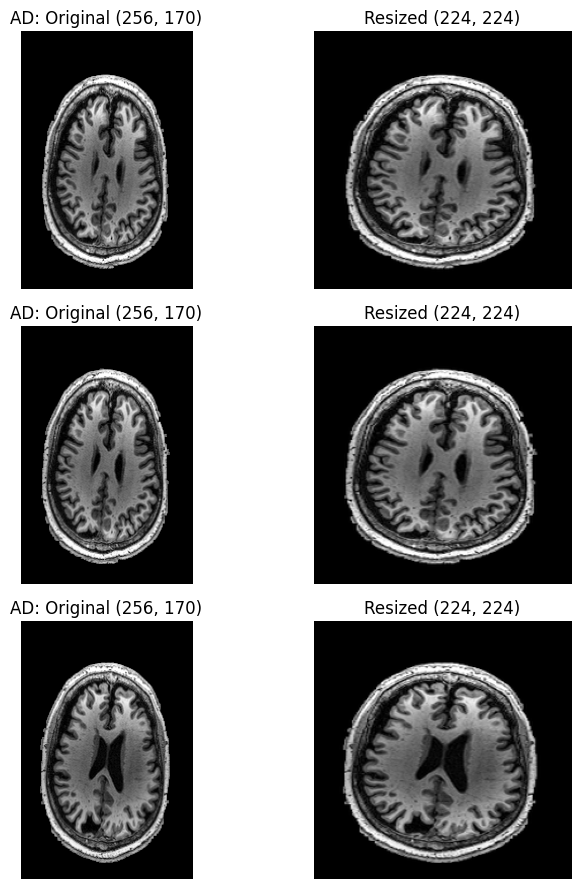

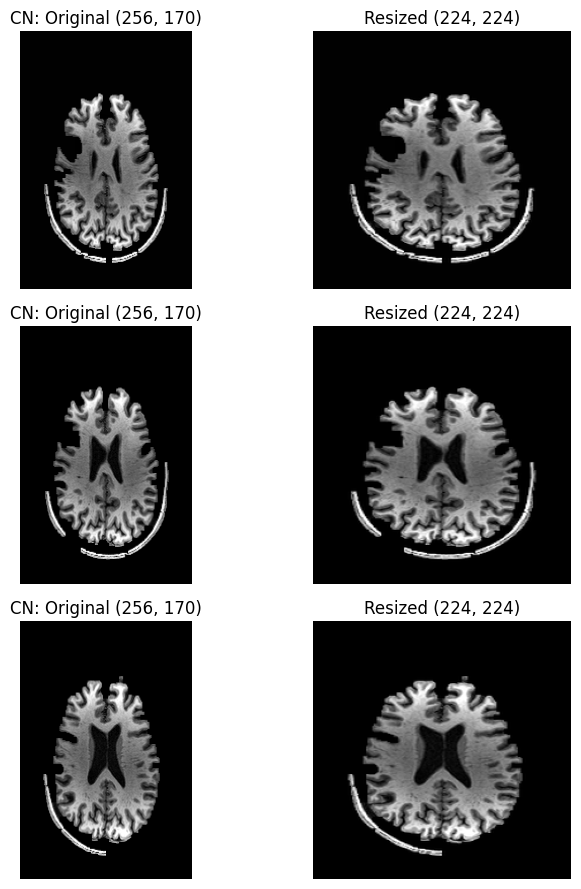

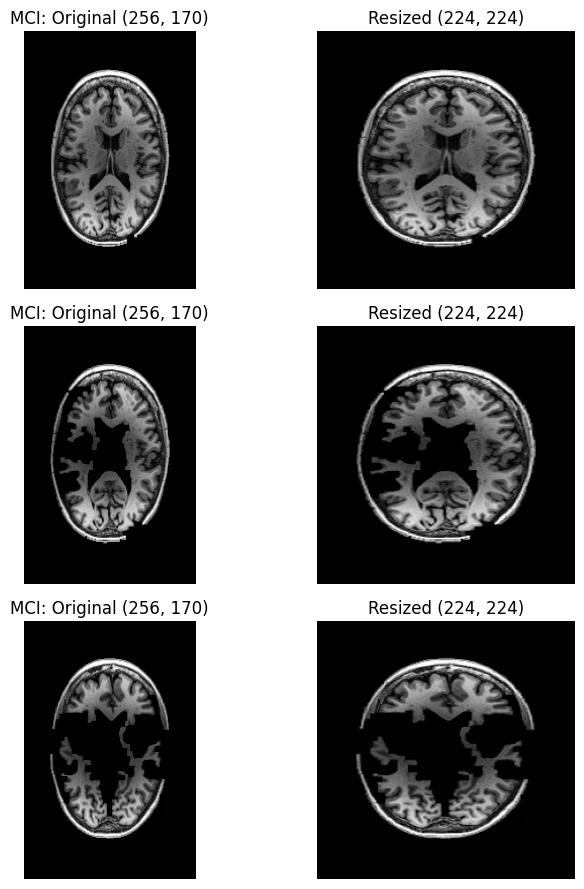

=== Resizing Preprocessed Images: TRAIN ===


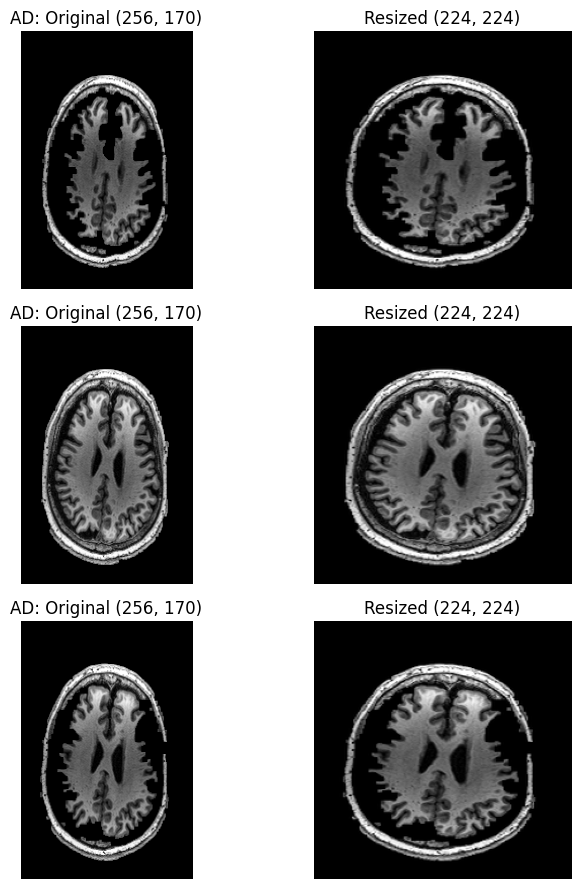

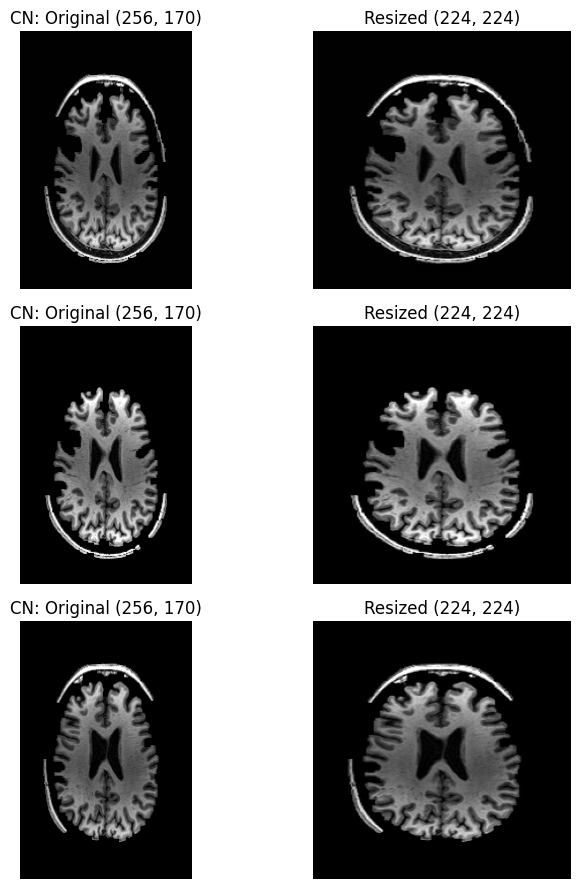

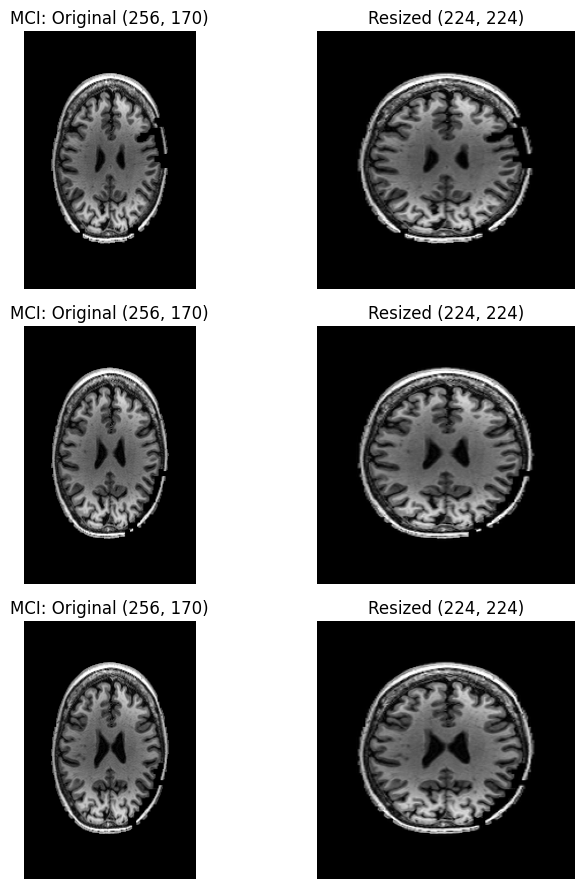

Resized images saved to:
  • Resized Test : /kaggle/working/alzheimer-resized-224/test
  • Resized Train: /kaggle/working/alzheimer-resized-224/train
Summary TEST : AD: 225 ok / 0 skipped, CN: 288 ok / 0 skipped, MCI: 518 ok / 0 skipped
Summary TRAIN: AD: 899 ok / 0 skipped, CN: 1152 ok / 0 skipped, MCI: 2072 ok / 0 skipped


In [3]:
import os
import numpy as np
from PIL import Image, UnidentifiedImageError
import matplotlib.pyplot as plt

test_dir = "/kaggle/input/alzheimer-disease/test-20251010T094612Z-1-001/test"
train_dir = "/kaggle/input/alzheimer-disease/train-20251010T183510Z-1-001/train"
subfolders = ["AD", "CN", "MCI"]

preprocessed_test = "/kaggle/working/alzheimer-preprocessed/test"
preprocessed_train = "/kaggle/working/alzheimer-preprocessed/train"
resized_root = "/kaggle/working/alzheimer-resized-224"
resized_test = os.path.join(resized_root, "test")
resized_train = os.path.join(resized_root, "train")

IMG_EXT = (".png", ".jpg", ".jpeg", ".bmp", ".tif", ".tiff")
TARGET_SIZE = (224, 224)

def ensure_dir(p: str):
    os.makedirs(p, exist_ok=True)

def load_gray(path: str) -> np.ndarray:
    return np.asarray(Image.open(path).convert("L"), dtype=np.uint8)

def resize_and_save_gray(arr_u8: np.ndarray, path: str):
    img = Image.fromarray(arr_u8, mode="L")
    img_resized = img.resize(TARGET_SIZE, Image.Resampling.LANCZOS)
    img_resized.save(path)

def resize_dataset(src_root: str, dst_root: str, n_preview: int = 3):
    ensure_dir(dst_root)
    summary = {}

    for cls in subfolders:
        src_cls = os.path.join(src_root, cls)
        dst_cls = os.path.join(dst_root, cls)
        ensure_dir(dst_cls)

        processed = skipped = 0
        if not os.path.isdir(src_cls):
            summary[cls] = (0, 0)
            continue

        files = sorted([f for f in os.listdir(src_cls) if f.lower().endswith(IMG_EXT)])

        for fname in files:
            spath = os.path.join(src_cls, fname)
            dpath = os.path.join(dst_cls, fname)
            try:
                arr = load_gray(spath)
                resize_and_save_gray(arr, dpath)
                processed += 1
            except (UnidentifiedImageError, OSError, RuntimeError, ValueError):
                skipped += 1
                continue

        summary[cls] = (processed, skipped)

        preview = files[:n_preview]
        if preview:
            fig, axs = plt.subplots(len(preview), 2, figsize=(8, 3*len(preview)))
            if len(preview) == 1:
                axs = np.expand_dims(axs, 0)
            for i, fname in enumerate(preview):
                sp = os.path.join(src_cls, fname)
                dp = os.path.join(dst_cls, fname)
                try:
                    orig = load_gray(sp)
                    resized = load_gray(dp)

                    axs[i, 0].imshow(orig, cmap="gray", vmin=0, vmax=255)
                    axs[i, 0].axis("off")
                    axs[i, 0].set_title(f"{cls}: Original {orig.shape}")
                    
                    axs[i, 1].imshow(resized, cmap="gray", vmin=0, vmax=255)
                    axs[i, 1].axis("off")
                    axs[i, 1].set_title(f"Resized {resized.shape}")
                except Exception:
                    continue
            plt.tight_layout()
            plt.show()

    return summary

print("=== Resizing Preprocessed Images: TEST ===")
sum_test = resize_dataset(preprocessed_test, resized_test, n_preview=3)

print("=== Resizing Preprocessed Images: TRAIN ===")
sum_train = resize_dataset(preprocessed_train, resized_train, n_preview=3)

def _fmt(s): return ", ".join([f"{k}: {v[0]} ok / {v[1]} skipped" for k, v in s.items()])
print("Resized images saved to:")
print(f"  • Resized Test : {resized_test}")
print(f"  • Resized Train: {resized_train}")
print("Summary TEST :", _fmt(sum_test))
print("Summary TRAIN:", _fmt(sum_train))

**Train And Test Split**

In [4]:
import os
import sys
import csv
import random
import shutil
from pathlib import Path
from typing import Dict, List, Tuple

# -----------------------------------------
# Configuration (modified for resized images)
# -----------------------------------------
# Source resized dataset (224x224)
RESIZED_ROOT = os.environ.get("RESIZED_ROOT", "/kaggle/working/alzheimer-resized-224")
SRC_TRAIN = os.path.join(RESIZED_ROOT, "train")
SRC_TEST  = os.path.join(RESIZED_ROOT, "test")

# Classes (same as before)
CLASSES = ["AD", "CN", "MCI"]

# Where to write splits
SPLITS_ROOT = "/kaggle/working/alzheimer-resized-224_splits"
os.makedirs(SPLITS_ROOT, exist_ok=True)

# The split ratios (train:test) you requested
RATIO_LIST = [
    (0.90, 0.10),
    (0.80, 0.20),
    (0.70, 0.30),
    (0.60, 0.40),
    (0.50, 0.50),
    (0.40, 0.60),
    (0.30, 0.70),
    (0.20, 0.80),
    (0.10, 0.90)
]

# Validation share taken from the training portion
VAL_FRACTION = 0.10

# Base random seed (deterministic builds). Each ratio derives its own seed.
BASE_SEED = 2025

# -----------------------------------------
# Helpers
# -----------------------------------------
IMG_EXTS = (".png", ".jpg", ".jpeg", ".bmp", ".tif", ".tiff")

def list_images_in_class(class_dir: str) -> List[str]:
    """Return absolute paths of all images in a class directory."""
    if not os.path.isdir(class_dir):
        return []
    files = sorted([
        str(Path(class_dir) / f) for f in os.listdir(class_dir)
        if f.lower().endswith(IMG_EXTS)
    ])
    return files

def gather_all_images() -> Dict[str, List[str]]:
    """
    Gather all resized images per class, from both 'train' and 'test'
    to form a single full pool for stratified splitting by ratio.
    """
    all_by_class = {c: [] for c in CLASSES}
    for c in CLASSES:
        # From resized train
        all_by_class[c].extend(list_images_in_class(os.path.join(SRC_TRAIN, c)))
        # From resized test
        all_by_class[c].extend(list_images_in_class(os.path.join(SRC_TEST, c)))
    return all_by_class

def ensure_dirs(*paths: str):
    for p in paths:
        os.makedirs(p, exist_ok=True)

def link_or_copy(src: str, dst: str):
    """Create a symlink; if not permitted, copy the file."""
    try:
        # Remove dst if exists
        if os.path.lexists(dst):
            os.unlink(dst)
        os.symlink(src, dst)
    except OSError:
        shutil.copy2(src, dst)

def write_manifest(split_dir: str, split_name: str, rows: List[Tuple[str, str, str, str]]):
    """
    Write both CSV manifest and plain path list.
    rows: list of (split, cls, filename, src_path)
    """
    # CSV
    csv_path = os.path.join(split_dir, f"{split_name}.csv")
    with open(csv_path, "w", newline="") as f:
        w = csv.writer(f)
        w.writerow(["split", "class", "filename", "path"])
        for r in rows:
            w.writerow(r)

    # TXT list
    txt_path = os.path.join(split_dir, f"{split_name}.txt")
    with open(txt_path, "w") as f:
        for _, _, _, p in rows:
            f.write(p + "\n")

def summarize_counts(counts: Dict[str, Dict[str, int]]):
    """
    Print counts per split (train/val/test) and per class for quick sanity check.
    """
    for split in ["train", "val", "test"]:
        info = counts.get(split, {})
        total = sum(info.values())
        detail = ", ".join([f"{k}: {v}" for k, v in info.items()])
        print(f"{split.capitalize():5s} => total {total:5d} | {detail}")

# -----------------------------------------
# Split builder
# -----------------------------------------
def build_splits():
    # 1) Pool all images by class (union of resized/train and resized/test)
    all_by_class = gather_all_images()

    # Optional: quick report of total availability
    print("Total images by class (union of resized/train + resized/test):")
    for c in CLASSES:
        print(f"  {c}: {len(all_by_class[c])}")

    # 2) For each (train_ratio, test_ratio), create a split folder and populate
    for tr_ratio, te_ratio in RATIO_LIST:
        # sanity: ratios sum approx 1
        assert abs(tr_ratio + te_ratio - 1.0) < 1e-6, "Train+Test ratio must sum to 1"

        # deterministic seed per ratio
        seed = BASE_SEED + int(round(te_ratio * 100))
        rng = random.Random(seed)

        # Split name and dirs
        split_name = f"split_{int(round(tr_ratio*100))}_{int(round(te_ratio*100))}"
        split_root = os.path.join(SPLITS_ROOT, split_name)
        train_root = os.path.join(split_root, "train")
        val_root   = os.path.join(split_root, "val")
        test_root  = os.path.join(split_root, "test")
        ensure_dirs(split_root, train_root, val_root, test_root)
        for c in CLASSES:
            ensure_dirs(os.path.join(train_root, c), os.path.join(val_root, c), os.path.join(test_root, c))

        rows_train, rows_val, rows_test = [], [], []
        counts = {"train": {}, "val": {}, "test": {}}

        # 3) Per-class stratified splitting
        for c in CLASSES:
            full_list = list(all_by_class[c])  # copy
            rng.shuffle(full_list)             # deterministic shuffle

            n_total = len(full_list)
            n_test  = max(0, int(round(n_total * te_ratio)))
            n_test  = min(n_test, n_total)  # guard

            test_list = full_list[:n_test]
            train_pool = full_list[n_test:]

            # Validation from training portion (10%)
            n_val = max(0, int(round(len(train_pool) * VAL_FRACTION)))
            val_list = train_pool[:n_val]
            train_list = train_pool[n_val:]

            # 4) Materialize (symlink/copy) into folders and write manifests
            # test
            for src_path in test_list:
                fname = os.path.basename(src_path)
                dst_path = os.path.join(test_root, c, fname)
                link_or_copy(src_path, dst_path)
                rows_test.append(("test", c, fname, dst_path))

            # val
            for src_path in val_list:
                fname = os.path.basename(src_path)
                dst_path = os.path.join(val_root, c, fname)
                link_or_copy(src_path, dst_path)
                rows_val.append(("val", c, fname, dst_path))

            # train
            for src_path in train_list:
                fname = os.path.basename(src_path)
                dst_path = os.path.join(train_root, c, fname)
                link_or_copy(src_path, dst_path)
                rows_train.append(("train", c, fname, dst_path))

            # counts
            counts["test"][c]  = len(test_list)
            counts["val"][c]   = len(val_list)
            counts["train"][c] = len(train_list)

        # 5) Write manifest files for this split
        write_manifest(split_root, "train", rows_train)
        write_manifest(split_root, "val",   rows_val)
        write_manifest(split_root, "test",  rows_test)

        # 6) Summary printout
        print(f"\n=== {split_name} ===")
        summarize_counts(counts)
        print(f"Paths:\n  Train: {train_root}\n  Val  : {val_root}\n  Test : {test_root}\n")

    # 7) Export env var for convenient access in later cells
    os.environ["RESIZED_SPLITS_ROOT"] = SPLITS_ROOT
    print(f"All splits created under: {SPLITS_ROOT}")

# -----------------------------------------
# Execute
# -----------------------------------------
build_splits()

Total images by class (union of resized/train + resized/test):
  AD: 1124
  CN: 1440
  MCI: 2590

=== split_90_10 ===
Train => total  4175 | AD: 911, CN: 1166, MCI: 2098
Val   => total   464 | AD: 101, CN: 130, MCI: 233
Test  => total   515 | AD: 112, CN: 144, MCI: 259
Paths:
  Train: /kaggle/working/alzheimer-resized-224_splits/split_90_10/train
  Val  : /kaggle/working/alzheimer-resized-224_splits/split_90_10/val
  Test : /kaggle/working/alzheimer-resized-224_splits/split_90_10/test


=== split_80_20 ===
Train => total  3711 | AD: 809, CN: 1037, MCI: 1865
Val   => total   412 | AD: 90, CN: 115, MCI: 207
Test  => total  1031 | AD: 225, CN: 288, MCI: 518
Paths:
  Train: /kaggle/working/alzheimer-resized-224_splits/split_80_20/train
  Val  : /kaggle/working/alzheimer-resized-224_splits/split_80_20/val
  Test : /kaggle/working/alzheimer-resized-224_splits/split_80_20/test


=== split_70_30 ===
Train => total  3247 | AD: 708, CN: 907, MCI: 1632
Val   => total   361 | AD: 79, CN: 101, MCI:

In [5]:
import os
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms, models
import pandas as pd
import numpy as np
from PIL import Image
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, classification_report
import time

class AlzheimerDataset(Dataset):
    def __init__(self, split_dir, split_type, transform=None):
        self.split_dir = split_dir
        self.split_type = split_type
        self.transform = transform
        
        csv_path = os.path.join(split_dir, f"{split_type}.csv")
        self.df = pd.read_csv(csv_path)
        
        self.class_to_idx = {"AD": 0, "CN": 1, "MCI": 2}
        self.idx_to_class = {v: k for k, v in self.class_to_idx.items()}
    
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img_path = row['path']
        label = self.class_to_idx[row['class']]
        
        image = Image.open(img_path).convert('RGB')
        
        if self.transform:
            image = self.transform(image)
        
        return image, label

def get_data_transforms():
    train_transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomRotation(10),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    
    val_transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    
    return train_transform, val_transform

def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs, device):
    model.train()
    
    for epoch in range(num_epochs):
        running_loss = 0.0
        correct = 0
        total = 0
        
        for batch_idx, (images, labels) in enumerate(train_loader):
            images, labels = images.to(device), labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        
        epoch_loss = running_loss / len(train_loader)
        epoch_acc = 100 * correct / total
        
        if (epoch + 1) % 5 == 0:
            val_acc = evaluate_model(model, val_loader, device)
            print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}, Train Acc: {epoch_acc:.2f}%, Val Acc: {val_acc:.2f}%')
        else:
            print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}, Train Acc: {epoch_acc:.2f}%')

def evaluate_model(model, data_loader, device):
    model.eval()
    correct = 0
    total = 0
    
    with torch.no_grad():
        for images, labels in data_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    accuracy = 100 * correct / total
    return accuracy

def test_model(model, test_loader, device):
    model.eval()
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    return all_preds, all_labels

def calculate_metrics(y_true, y_pred, split_name):
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='weighted', zero_division=0)
    recall = recall_score(y_true, y_pred, average='weighted', zero_division=0)
    f1 = f1_score(y_true, y_pred, average='weighted', zero_division=0)
    
    print(f"\n=== {split_name} Results ===")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-Score: {f1:.4f}")
    print("\nClassification Report:")
    print(classification_report(y_true, y_pred, target_names=['AD', 'CN', 'MCI'], zero_division=0))
    
    return {
        'split': split_name,
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_score': f1
    }

def run_resnet50_on_splits():
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")
    
    splits_root = "/kaggle/working/alzheimer-resized-224_splits"
    split_folders = [f for f in os.listdir(splits_root) if f.startswith('split_')]
    split_folders.sort()
    
    results = []
    
    train_transform, val_transform = get_data_transforms()
    
    for split_folder in split_folders:
        print(f"\n{'='*60}")
        print(f"Processing: {split_folder}")
        print(f"{'='*60}")
        
        split_path = os.path.join(splits_root, split_folder)
        
        train_dataset = AlzheimerDataset(split_path, 'train', train_transform)
        val_dataset = AlzheimerDataset(split_path, 'val', val_transform)
        test_dataset = AlzheimerDataset(split_path, 'test', val_transform)
        
        train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2)
        val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=2)
        test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=2)
        
        print(f"Train samples: {len(train_dataset)}")
        print(f"Val samples: {len(val_dataset)}")
        print(f"Test samples: {len(test_dataset)}")
        
        model = models.resnet50(pretrained=True)
        num_ftrs = model.fc.in_features
        model.fc = nn.Linear(num_ftrs, 3)
        model = model.to(device)
        
        criterion = nn.CrossEntropyLoss()
        optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)
        
        print("Starting training...")
        start_time = time.time()
        train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=20, device=device)
        training_time = time.time() - start_time
        
        print("Testing model...")
        test_preds, test_labels = test_model(model, test_loader, device)
        
        split_results = calculate_metrics(test_labels, test_preds, split_folder)
        split_results['training_time'] = training_time
        results.append(split_results)
        
        torch.cuda.empty_cache()
    
    results_df = pd.DataFrame(results)
    print(f"\n{'='*80}")
    print("SUMMARY OF ALL SPLITS")
    print(f"{'='*80}")
    print(results_df.to_string(index=False))
    
    results_csv_path = "/kaggle/working/resnet50_results.csv"
    results_df.to_csv(results_csv_path, index=False)
    print(f"\nDetailed results saved to: {results_csv_path}")
    
    return results_df

if __name__ == "__main__":
    results = run_resnet50_on_splits()

Using device: cuda

Processing: split_10_90
Train samples: 464
Val samples: 51
Test samples: 4639


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 239MB/s]


Starting training...
Epoch [1/20], Loss: 1.2562, Train Acc: 45.04%
Epoch [2/20], Loss: 1.0173, Train Acc: 50.22%
Epoch [3/20], Loss: 1.0674, Train Acc: 45.69%
Epoch [4/20], Loss: 1.0026, Train Acc: 53.02%
Epoch [5/20], Loss: 0.9894, Train Acc: 54.09%, Val Acc: 54.90%
Epoch [6/20], Loss: 1.3128, Train Acc: 42.89%
Epoch [7/20], Loss: 1.0429, Train Acc: 50.22%
Epoch [8/20], Loss: 1.0468, Train Acc: 50.22%
Epoch [9/20], Loss: 1.0419, Train Acc: 50.22%
Epoch [10/20], Loss: 1.0388, Train Acc: 50.22%, Val Acc: 50.98%
Epoch [11/20], Loss: 1.0421, Train Acc: 50.22%
Epoch [12/20], Loss: 1.0380, Train Acc: 50.22%
Epoch [13/20], Loss: 1.0394, Train Acc: 50.22%
Epoch [14/20], Loss: 1.0581, Train Acc: 50.22%
Epoch [15/20], Loss: 1.0343, Train Acc: 50.22%, Val Acc: 50.98%
Epoch [16/20], Loss: 1.0429, Train Acc: 50.22%
Epoch [17/20], Loss: 1.0409, Train Acc: 50.22%
Epoch [18/20], Loss: 1.0469, Train Acc: 50.22%
Epoch [19/20], Loss: 1.0390, Train Acc: 50.22%
Epoch [20/20], Loss: 1.0372, Train Acc: 50.2

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Starting training...
Epoch [1/20], Loss: 1.1361, Train Acc: 47.84%
Epoch [2/20], Loss: 1.0316, Train Acc: 49.89%
Epoch [3/20], Loss: 0.9685, Train Acc: 50.75%
Epoch [4/20], Loss: 1.0074, Train Acc: 49.14%
Epoch [5/20], Loss: 0.9550, Train Acc: 50.86%, Val Acc: 48.54%
Epoch [6/20], Loss: 1.5994, Train Acc: 42.78%
Epoch [7/20], Loss: 1.0431, Train Acc: 50.22%
Epoch [8/20], Loss: 1.0405, Train Acc: 50.22%
Epoch [9/20], Loss: 1.0404, Train Acc: 50.22%
Epoch [10/20], Loss: 1.0383, Train Acc: 50.22%, Val Acc: 50.49%
Epoch [11/20], Loss: 1.0403, Train Acc: 50.22%
Epoch [12/20], Loss: 1.0397, Train Acc: 50.22%
Epoch [13/20], Loss: 1.0388, Train Acc: 50.22%
Epoch [14/20], Loss: 1.0378, Train Acc: 50.22%
Epoch [15/20], Loss: 1.0373, Train Acc: 50.22%, Val Acc: 50.49%
Epoch [16/20], Loss: 1.0383, Train Acc: 50.22%
Epoch [17/20], Loss: 1.0385, Train Acc: 50.22%
Epoch [18/20], Loss: 1.0372, Train Acc: 50.22%
Epoch [19/20], Loss: 1.0360, Train Acc: 50.22%
Epoch [20/20], Loss: 1.0359, Train Acc: 50.2

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Starting training...
Epoch [1/20], Loss: 1.1615, Train Acc: 45.51%
Epoch [2/20], Loss: 1.0387, Train Acc: 49.60%
Epoch [3/20], Loss: 0.9807, Train Acc: 52.77%
Epoch [4/20], Loss: 1.0041, Train Acc: 52.91%
Epoch [5/20], Loss: 0.9963, Train Acc: 53.20%, Val Acc: 49.68%
Epoch [6/20], Loss: 1.0442, Train Acc: 50.54%
Epoch [7/20], Loss: 1.0387, Train Acc: 50.25%
Epoch [8/20], Loss: 1.0397, Train Acc: 50.25%
Epoch [9/20], Loss: 1.0377, Train Acc: 50.25%
Epoch [10/20], Loss: 1.0339, Train Acc: 50.25%, Val Acc: 50.32%
Epoch [11/20], Loss: 1.0368, Train Acc: 50.25%
Epoch [12/20], Loss: 1.0337, Train Acc: 50.25%
Epoch [13/20], Loss: 1.0397, Train Acc: 50.25%
Epoch [14/20], Loss: 1.0352, Train Acc: 50.25%
Epoch [15/20], Loss: 1.0373, Train Acc: 50.25%, Val Acc: 50.32%
Epoch [16/20], Loss: 1.0362, Train Acc: 50.25%
Epoch [17/20], Loss: 1.0374, Train Acc: 50.25%
Epoch [18/20], Loss: 1.0371, Train Acc: 50.25%
Epoch [19/20], Loss: 1.0343, Train Acc: 50.25%
Epoch [20/20], Loss: 1.0368, Train Acc: 50.2

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Starting training...
Epoch [1/20], Loss: 1.1146, Train Acc: 47.76%
Epoch [2/20], Loss: 1.0216, Train Acc: 50.89%
Epoch [3/20], Loss: 0.9853, Train Acc: 52.61%
Epoch [4/20], Loss: 0.9399, Train Acc: 56.28%
Epoch [5/20], Loss: 0.9504, Train Acc: 53.96%, Val Acc: 54.11%
Epoch [6/20], Loss: 1.0371, Train Acc: 50.30%
Epoch [7/20], Loss: 1.0392, Train Acc: 50.24%
Epoch [8/20], Loss: 1.0377, Train Acc: 50.24%
Epoch [9/20], Loss: 1.0360, Train Acc: 50.24%
Epoch [10/20], Loss: 1.0388, Train Acc: 50.24%, Val Acc: 50.24%
Epoch [11/20], Loss: 1.0364, Train Acc: 50.24%
Epoch [12/20], Loss: 1.0363, Train Acc: 50.24%
Epoch [13/20], Loss: 1.0388, Train Acc: 50.24%
Epoch [14/20], Loss: 1.0372, Train Acc: 50.24%
Epoch [15/20], Loss: 1.0405, Train Acc: 50.24%, Val Acc: 50.24%
Epoch [16/20], Loss: 1.0389, Train Acc: 50.24%
Epoch [17/20], Loss: 1.0377, Train Acc: 50.24%
Epoch [18/20], Loss: 1.0367, Train Acc: 50.24%
Epoch [19/20], Loss: 1.0361, Train Acc: 50.24%
Epoch [20/20], Loss: 1.0366, Train Acc: 50.2

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Starting training...
Epoch [1/20], Loss: 1.0507, Train Acc: 49.85%
Epoch [2/20], Loss: 0.9607, Train Acc: 54.59%
Epoch [3/20], Loss: 0.9444, Train Acc: 55.07%
Epoch [4/20], Loss: 0.8993, Train Acc: 57.61%
Epoch [5/20], Loss: 0.8808, Train Acc: 59.34%, Val Acc: 58.14%
Epoch [6/20], Loss: 1.1933, Train Acc: 48.56%
Epoch [7/20], Loss: 1.0405, Train Acc: 50.24%
Epoch [8/20], Loss: 1.0354, Train Acc: 50.24%
Epoch [9/20], Loss: 1.0374, Train Acc: 50.24%
Epoch [10/20], Loss: 1.0369, Train Acc: 50.24%, Val Acc: 50.39%
Epoch [11/20], Loss: 1.0359, Train Acc: 50.24%
Epoch [12/20], Loss: 1.0355, Train Acc: 50.24%
Epoch [13/20], Loss: 1.0378, Train Acc: 50.24%
Epoch [14/20], Loss: 1.0362, Train Acc: 50.24%
Epoch [15/20], Loss: 1.0385, Train Acc: 50.24%, Val Acc: 50.39%
Epoch [16/20], Loss: 1.0367, Train Acc: 50.24%
Epoch [17/20], Loss: 1.0373, Train Acc: 50.24%
Epoch [18/20], Loss: 1.0375, Train Acc: 50.24%
Epoch [19/20], Loss: 1.0357, Train Acc: 50.24%
Epoch [20/20], Loss: 1.0372, Train Acc: 50.2

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Starting training...
Epoch [1/20], Loss: 1.0739, Train Acc: 47.56%
Epoch [2/20], Loss: 0.9827, Train Acc: 52.05%
Epoch [3/20], Loss: 0.8996, Train Acc: 58.23%
Epoch [4/20], Loss: 0.8544, Train Acc: 62.28%
Epoch [5/20], Loss: 0.7703, Train Acc: 67.21%, Val Acc: 61.69%
Epoch [6/20], Loss: 1.3883, Train Acc: 49.68%
Epoch [7/20], Loss: 1.0357, Train Acc: 50.25%
Epoch [8/20], Loss: 1.0366, Train Acc: 50.25%
Epoch [9/20], Loss: 1.0346, Train Acc: 50.25%
Epoch [10/20], Loss: 1.0362, Train Acc: 50.25%, Val Acc: 50.32%
Epoch [11/20], Loss: 1.0353, Train Acc: 50.25%
Epoch [12/20], Loss: 1.0354, Train Acc: 50.25%
Epoch [13/20], Loss: 1.0357, Train Acc: 50.25%
Epoch [14/20], Loss: 1.0363, Train Acc: 50.25%
Epoch [15/20], Loss: 1.0351, Train Acc: 50.25%, Val Acc: 50.32%
Epoch [16/20], Loss: 1.0357, Train Acc: 50.25%
Epoch [17/20], Loss: 1.0354, Train Acc: 50.25%
Epoch [18/20], Loss: 1.0356, Train Acc: 50.25%
Epoch [19/20], Loss: 1.0349, Train Acc: 50.25%
Epoch [20/20], Loss: 1.0350, Train Acc: 50.2

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Starting training...
Epoch [1/20], Loss: 1.0474, Train Acc: 50.42%
Epoch [2/20], Loss: 0.9833, Train Acc: 53.28%
Epoch [3/20], Loss: 0.9431, Train Acc: 55.56%
Epoch [4/20], Loss: 0.8861, Train Acc: 57.81%
Epoch [5/20], Loss: 0.8409, Train Acc: 60.43%, Val Acc: 57.89%
Epoch [6/20], Loss: 1.0109, Train Acc: 52.20%
Epoch [7/20], Loss: 0.9975, Train Acc: 52.39%
Epoch [8/20], Loss: 0.9932, Train Acc: 52.36%
Epoch [9/20], Loss: 0.9672, Train Acc: 54.39%
Epoch [10/20], Loss: 0.9530, Train Acc: 54.76%, Val Acc: 54.02%
Epoch [11/20], Loss: 0.9428, Train Acc: 54.64%
Epoch [12/20], Loss: 0.9019, Train Acc: 57.93%
Epoch [13/20], Loss: 0.8991, Train Acc: 58.21%
Epoch [14/20], Loss: 0.8771, Train Acc: 59.75%
Epoch [15/20], Loss: 0.8597, Train Acc: 60.02%, Val Acc: 63.16%
Epoch [16/20], Loss: 0.8186, Train Acc: 63.04%
Epoch [17/20], Loss: 0.7817, Train Acc: 65.72%
Epoch [18/20], Loss: 0.7691, Train Acc: 67.17%
Epoch [19/20], Loss: 0.7552, Train Acc: 67.29%
Epoch [20/20], Loss: 0.6886, Train Acc: 70.8

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Starting training...
Epoch [1/20], Loss: 1.0629, Train Acc: 49.53%
Epoch [2/20], Loss: 0.9749, Train Acc: 51.50%
Epoch [3/20], Loss: 0.9263, Train Acc: 56.67%
Epoch [4/20], Loss: 0.8834, Train Acc: 58.45%
Epoch [5/20], Loss: 0.8171, Train Acc: 62.62%, Val Acc: 64.81%
Epoch [6/20], Loss: 1.4766, Train Acc: 49.56%
Epoch [7/20], Loss: 1.0362, Train Acc: 50.26%
Epoch [8/20], Loss: 1.0358, Train Acc: 50.26%
Epoch [9/20], Loss: 1.0362, Train Acc: 50.26%
Epoch [10/20], Loss: 1.0360, Train Acc: 50.26%, Val Acc: 50.24%
Epoch [11/20], Loss: 1.0356, Train Acc: 50.26%
Epoch [12/20], Loss: 1.0355, Train Acc: 50.26%
Epoch [13/20], Loss: 1.0365, Train Acc: 50.26%
Epoch [14/20], Loss: 1.0348, Train Acc: 50.26%
Epoch [15/20], Loss: 1.0360, Train Acc: 50.26%, Val Acc: 50.24%
Epoch [16/20], Loss: 1.0358, Train Acc: 50.26%
Epoch [17/20], Loss: 1.0357, Train Acc: 50.26%
Epoch [18/20], Loss: 1.0348, Train Acc: 50.26%
Epoch [19/20], Loss: 1.0362, Train Acc: 50.26%
Epoch [20/20], Loss: 1.0355, Train Acc: 50.2

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Starting training...
Epoch [1/20], Loss: 1.0612, Train Acc: 48.50%
Epoch [2/20], Loss: 0.9523, Train Acc: 54.28%
Epoch [3/20], Loss: 0.8508, Train Acc: 61.37%
Epoch [4/20], Loss: 0.7765, Train Acc: 66.04%
Epoch [5/20], Loss: 0.7088, Train Acc: 70.42%, Val Acc: 75.22%
Epoch [6/20], Loss: 1.1990, Train Acc: 49.82%
Epoch [7/20], Loss: 1.0371, Train Acc: 50.25%
Epoch [8/20], Loss: 1.0362, Train Acc: 50.25%
Epoch [9/20], Loss: 1.0358, Train Acc: 50.25%
Epoch [10/20], Loss: 1.0351, Train Acc: 50.25%, Val Acc: 50.22%
Epoch [11/20], Loss: 1.0355, Train Acc: 50.25%
Epoch [12/20], Loss: 1.0348, Train Acc: 50.25%
Epoch [13/20], Loss: 1.0350, Train Acc: 50.25%
Epoch [14/20], Loss: 1.0367, Train Acc: 50.25%
Epoch [15/20], Loss: 1.0356, Train Acc: 50.25%, Val Acc: 50.22%
Epoch [16/20], Loss: 1.0359, Train Acc: 50.25%
Epoch [17/20], Loss: 1.0351, Train Acc: 50.25%
Epoch [18/20], Loss: 1.0358, Train Acc: 50.25%
Epoch [19/20], Loss: 1.0360, Train Acc: 50.25%
Epoch [20/20], Loss: 1.0340, Train Acc: 50.2

In [6]:
import os
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms, models
import pandas as pd
import numpy as np
from PIL import Image
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, classification_report
import time

class AlzheimerDataset(Dataset):
    def __init__(self, split_dir, split_type, transform=None):
        self.split_dir = split_dir
        self.split_type = split_type
        self.transform = transform
        
        csv_path = os.path.join(split_dir, f"{split_type}.csv")
        self.df = pd.read_csv(csv_path)
        
        self.class_to_idx = {"AD": 0, "CN": 1, "MCI": 2}
        self.idx_to_class = {v: k for k, v in self.class_to_idx.items()}
    
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img_path = row['path']
        label = self.class_to_idx[row['class']]
        
        image = Image.open(img_path).convert('RGB')
        
        if self.transform:
            image = self.transform(image)
        
        return image, label

def get_data_transforms():
    train_transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomRotation(10),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    
    val_transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    
    return train_transform, val_transform

def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs, device):
    model.train()
    
    for epoch in range(num_epochs):
        running_loss = 0.0
        correct = 0
        total = 0
        
        for batch_idx, (images, labels) in enumerate(train_loader):
            images, labels = images.to(device), labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        
        epoch_loss = running_loss / len(train_loader)
        epoch_acc = 100 * correct / total
        
        if (epoch + 1) % 5 == 0:
            val_acc = evaluate_model(model, val_loader, device)
            print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}, Train Acc: {epoch_acc:.2f}%, Val Acc: {val_acc:.2f}%')
        else:
            print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}, Train Acc: {epoch_acc:.2f}%')

def evaluate_model(model, data_loader, device):
    model.eval()
    correct = 0
    total = 0
    
    with torch.no_grad():
        for images, labels in data_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    accuracy = 100 * correct / total
    return accuracy

def test_model(model, test_loader, device):
    model.eval()
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    return all_preds, all_labels

def calculate_metrics(y_true, y_pred, split_name):
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='weighted', zero_division=0)
    recall = recall_score(y_true, y_pred, average='weighted', zero_division=0)
    f1 = f1_score(y_true, y_pred, average='weighted', zero_division=0)
    
    print(f"\n=== {split_name} Results ===")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-Score: {f1:.4f}")
    print("\nClassification Report:")
    print(classification_report(y_true, y_pred, target_names=['AD', 'CN', 'MCI'], zero_division=0))
    
    return {
        'split': split_name,
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_score': f1
    }

def run_vgg16_on_splits():
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")
    
    splits_root = "/kaggle/working/alzheimer-resized-224_splits"
    split_folders = [f for f in os.listdir(splits_root) if f.startswith('split_')]
    split_folders.sort()
    
    results = []
    
    train_transform, val_transform = get_data_transforms()
    
    for split_folder in split_folders:
        print(f"\n{'='*60}")
        print(f"Processing: {split_folder}")
        print(f"{'='*60}")
        
        split_path = os.path.join(splits_root, split_folder)
        
        train_dataset = AlzheimerDataset(split_path, 'train', train_transform)
        val_dataset = AlzheimerDataset(split_path, 'val', val_transform)
        test_dataset = AlzheimerDataset(split_path, 'test', val_transform)
        
        train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2)
        val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=2)
        test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=2)
        
        print(f"Train samples: {len(train_dataset)}")
        print(f"Val samples: {len(val_dataset)}")
        print(f"Test samples: {len(test_dataset)}")
        
        model = models.vgg16(pretrained=True)
        num_ftrs = model.classifier[6].in_features
        model.classifier[6] = nn.Linear(num_ftrs, 3)
        model = model.to(device)
        
        criterion = nn.CrossEntropyLoss()
        optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)
        
        print("Starting training...")
        start_time = time.time()
        train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=20, device=device)
        training_time = time.time() - start_time
        
        print("Testing model...")
        test_preds, test_labels = test_model(model, test_loader, device)
        
        split_results = calculate_metrics(test_labels, test_preds, split_folder)
        split_results['training_time'] = training_time
        results.append(split_results)
        
        torch.cuda.empty_cache()
    
    results_df = pd.DataFrame(results)
    print(f"\n{'='*80}")
    print("VGG16 - SUMMARY OF ALL SPLITS")
    print(f"{'='*80}")
    print(results_df.to_string(index=False))
    
    results_csv_path = "/kaggle/working/vgg16_results.csv"
    results_df.to_csv(results_csv_path, index=False)
    print(f"\nDetailed results saved to: {results_csv_path}")
    
    return results_df

if __name__ == "__main__":
    results = run_vgg16_on_splits()

Using device: cuda

Processing: split_10_90
Train samples: 464
Val samples: 51
Test samples: 4639


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:02<00:00, 218MB/s]


Starting training...
Epoch [1/20], Loss: 4.9158, Train Acc: 38.36%
Epoch [2/20], Loss: 1.3102, Train Acc: 44.40%
Epoch [3/20], Loss: 1.1013, Train Acc: 49.57%
Epoch [4/20], Loss: 1.0320, Train Acc: 50.22%
Epoch [5/20], Loss: 1.0937, Train Acc: 50.00%, Val Acc: 27.45%
Epoch [6/20], Loss: 1.0638, Train Acc: 48.71%
Epoch [7/20], Loss: 1.0692, Train Acc: 50.22%
Epoch [8/20], Loss: 1.0419, Train Acc: 50.22%
Epoch [9/20], Loss: 1.0401, Train Acc: 50.22%
Epoch [10/20], Loss: 1.0392, Train Acc: 50.22%, Val Acc: 50.98%
Epoch [11/20], Loss: 1.0416, Train Acc: 50.22%
Epoch [12/20], Loss: 1.0345, Train Acc: 50.22%
Epoch [13/20], Loss: 1.0398, Train Acc: 50.22%
Epoch [14/20], Loss: 1.0385, Train Acc: 50.22%
Epoch [15/20], Loss: 1.0422, Train Acc: 50.22%, Val Acc: 50.98%
Epoch [16/20], Loss: 1.0368, Train Acc: 50.22%
Epoch [17/20], Loss: 1.0795, Train Acc: 48.28%
Epoch [18/20], Loss: 1.0605, Train Acc: 50.22%
Epoch [19/20], Loss: 1.0412, Train Acc: 50.22%
Epoch [20/20], Loss: 1.0279, Train Acc: 50.2

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Starting training...
Epoch [1/20], Loss: 1.2561, Train Acc: 46.34%
Epoch [2/20], Loss: 1.0512, Train Acc: 49.78%
Epoch [3/20], Loss: 1.0452, Train Acc: 50.22%
Epoch [4/20], Loss: 1.1011, Train Acc: 46.44%
Epoch [5/20], Loss: 1.0482, Train Acc: 49.89%, Val Acc: 50.49%
Epoch [6/20], Loss: 1.2014, Train Acc: 45.47%
Epoch [7/20], Loss: 1.0538, Train Acc: 48.71%
Epoch [8/20], Loss: 1.0610, Train Acc: 50.22%
Epoch [9/20], Loss: 1.0525, Train Acc: 48.71%
Epoch [10/20], Loss: 1.0384, Train Acc: 50.22%, Val Acc: 50.49%
Epoch [11/20], Loss: 1.2438, Train Acc: 50.00%
Epoch [12/20], Loss: 1.2481, Train Acc: 47.41%
Epoch [13/20], Loss: 1.2909, Train Acc: 47.63%
Epoch [14/20], Loss: 1.0472, Train Acc: 49.14%
Epoch [15/20], Loss: 1.0509, Train Acc: 50.22%, Val Acc: 50.49%
Epoch [16/20], Loss: 1.0408, Train Acc: 50.54%
Epoch [17/20], Loss: 1.0627, Train Acc: 48.71%
Epoch [18/20], Loss: 1.0362, Train Acc: 50.22%
Epoch [19/20], Loss: 1.0380, Train Acc: 50.22%
Epoch [20/20], Loss: 1.0384, Train Acc: 50.2

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Starting training...
Epoch [1/20], Loss: 1.2476, Train Acc: 45.00%
Epoch [2/20], Loss: 1.0563, Train Acc: 50.40%
Epoch [3/20], Loss: 1.0443, Train Acc: 50.25%
Epoch [4/20], Loss: 1.0483, Train Acc: 50.18%
Epoch [5/20], Loss: 1.0702, Train Acc: 48.89%, Val Acc: 27.74%
Epoch [6/20], Loss: 1.5954, Train Acc: 45.79%
Epoch [7/20], Loss: 1.0419, Train Acc: 50.25%
Epoch [8/20], Loss: 1.0371, Train Acc: 50.25%
Epoch [9/20], Loss: 1.0410, Train Acc: 50.25%
Epoch [10/20], Loss: 1.1349, Train Acc: 49.96%, Val Acc: 50.32%
Epoch [11/20], Loss: 1.0866, Train Acc: 49.25%
Epoch [12/20], Loss: 1.0498, Train Acc: 49.39%
Epoch [13/20], Loss: 1.0392, Train Acc: 50.25%
Epoch [14/20], Loss: 1.0377, Train Acc: 50.25%
Epoch [15/20], Loss: 1.0378, Train Acc: 50.04%, Val Acc: 50.32%
Epoch [16/20], Loss: 1.0404, Train Acc: 50.25%
Epoch [17/20], Loss: 1.0370, Train Acc: 50.25%
Epoch [18/20], Loss: 1.0349, Train Acc: 50.25%
Epoch [19/20], Loss: 1.0372, Train Acc: 50.25%
Epoch [20/20], Loss: 1.0371, Train Acc: 50.2

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Starting training...
Epoch [1/20], Loss: 1.4620, Train Acc: 47.06%
Epoch [2/20], Loss: 1.0439, Train Acc: 50.08%
Epoch [3/20], Loss: 1.0531, Train Acc: 49.11%
Epoch [4/20], Loss: 1.0416, Train Acc: 50.24%
Epoch [5/20], Loss: 1.1092, Train Acc: 47.87%, Val Acc: 50.24%
Epoch [6/20], Loss: 1.0434, Train Acc: 50.24%
Epoch [7/20], Loss: 1.0396, Train Acc: 50.24%
Epoch [8/20], Loss: 1.0374, Train Acc: 50.24%
Epoch [9/20], Loss: 1.0366, Train Acc: 50.24%
Epoch [10/20], Loss: 1.0467, Train Acc: 50.24%, Val Acc: 50.24%
Epoch [11/20], Loss: 1.0780, Train Acc: 49.54%
Epoch [12/20], Loss: 1.0396, Train Acc: 50.24%
Epoch [13/20], Loss: 1.0388, Train Acc: 50.24%
Epoch [14/20], Loss: 1.0375, Train Acc: 50.24%
Epoch [15/20], Loss: 1.0493, Train Acc: 49.97%, Val Acc: 50.24%
Epoch [16/20], Loss: 1.0861, Train Acc: 49.60%
Epoch [17/20], Loss: 1.4273, Train Acc: 47.17%
Epoch [18/20], Loss: 1.0508, Train Acc: 49.33%
Epoch [19/20], Loss: 1.0366, Train Acc: 50.24%
Epoch [20/20], Loss: 1.0430, Train Acc: 50.2

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Starting training...
Epoch [1/20], Loss: 1.1266, Train Acc: 47.43%
Epoch [2/20], Loss: 1.0430, Train Acc: 50.15%
Epoch [3/20], Loss: 1.0520, Train Acc: 49.59%
Epoch [4/20], Loss: 1.0406, Train Acc: 50.24%
Epoch [5/20], Loss: 1.0815, Train Acc: 47.69%, Val Acc: 50.39%
Epoch [6/20], Loss: 1.0437, Train Acc: 48.99%
Epoch [7/20], Loss: 1.0389, Train Acc: 50.24%
Epoch [8/20], Loss: 1.0393, Train Acc: 50.24%
Epoch [9/20], Loss: 1.0853, Train Acc: 49.03%
Epoch [10/20], Loss: 1.0384, Train Acc: 50.24%, Val Acc: 50.39%
Epoch [11/20], Loss: 1.0354, Train Acc: 50.24%
Epoch [12/20], Loss: 1.0373, Train Acc: 50.24%
Epoch [13/20], Loss: 1.0402, Train Acc: 50.24%
Epoch [14/20], Loss: 1.0387, Train Acc: 50.24%
Epoch [15/20], Loss: 1.0370, Train Acc: 50.24%, Val Acc: 50.39%
Epoch [16/20], Loss: 1.0362, Train Acc: 50.24%
Epoch [17/20], Loss: 1.0359, Train Acc: 50.24%
Epoch [18/20], Loss: 1.5279, Train Acc: 47.52%
Epoch [19/20], Loss: 1.0597, Train Acc: 47.22%
Epoch [20/20], Loss: 1.0384, Train Acc: 50.2

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Starting training...
Epoch [1/20], Loss: 1.2046, Train Acc: 48.35%
Epoch [2/20], Loss: 1.0405, Train Acc: 50.29%
Epoch [3/20], Loss: 1.0770, Train Acc: 48.53%
Epoch [4/20], Loss: 1.0459, Train Acc: 49.93%
Epoch [5/20], Loss: 1.0383, Train Acc: 50.25%, Val Acc: 50.32%
Epoch [6/20], Loss: 1.0416, Train Acc: 50.25%
Epoch [7/20], Loss: 1.0382, Train Acc: 50.25%
Epoch [8/20], Loss: 1.0474, Train Acc: 49.86%
Epoch [9/20], Loss: 1.1631, Train Acc: 48.71%
Epoch [10/20], Loss: 1.0377, Train Acc: 50.25%, Val Acc: 50.32%
Epoch [11/20], Loss: 1.0364, Train Acc: 50.25%
Epoch [12/20], Loss: 1.0363, Train Acc: 50.25%
Epoch [13/20], Loss: 1.0356, Train Acc: 50.25%
Epoch [14/20], Loss: 1.0359, Train Acc: 50.25%
Epoch [15/20], Loss: 1.3435, Train Acc: 49.43%, Val Acc: 50.32%
Epoch [16/20], Loss: 1.3149, Train Acc: 48.74%
Epoch [17/20], Loss: 1.0348, Train Acc: 50.25%
Epoch [18/20], Loss: 1.0453, Train Acc: 50.00%
Epoch [19/20], Loss: 1.0364, Train Acc: 50.25%
Epoch [20/20], Loss: 1.0372, Train Acc: 50.2

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Starting training...
Epoch [1/20], Loss: 1.0992, Train Acc: 48.48%
Epoch [2/20], Loss: 1.0434, Train Acc: 50.26%
Epoch [3/20], Loss: 1.1641, Train Acc: 49.09%
Epoch [4/20], Loss: 1.0472, Train Acc: 49.65%
Epoch [5/20], Loss: 1.0393, Train Acc: 50.26%, Val Acc: 50.14%
Epoch [6/20], Loss: 1.0369, Train Acc: 50.26%
Epoch [7/20], Loss: 1.0364, Train Acc: 50.26%
Epoch [8/20], Loss: 1.0383, Train Acc: 50.26%
Epoch [9/20], Loss: 1.0387, Train Acc: 50.26%
Epoch [10/20], Loss: 1.1400, Train Acc: 48.20%, Val Acc: 50.14%
Epoch [11/20], Loss: 1.0366, Train Acc: 50.26%
Epoch [12/20], Loss: 1.0357, Train Acc: 50.26%
Epoch [13/20], Loss: 1.0353, Train Acc: 50.26%
Epoch [14/20], Loss: 1.0348, Train Acc: 50.26%
Epoch [15/20], Loss: 1.0351, Train Acc: 50.26%, Val Acc: 50.14%
Epoch [16/20], Loss: 1.0356, Train Acc: 50.26%
Epoch [17/20], Loss: 1.0376, Train Acc: 50.26%
Epoch [18/20], Loss: 1.0371, Train Acc: 50.26%
Epoch [19/20], Loss: 1.0353, Train Acc: 50.26%
Epoch [20/20], Loss: 1.0465, Train Acc: 50.2

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Starting training...
Epoch [1/20], Loss: 1.0957, Train Acc: 47.64%
Epoch [2/20], Loss: 1.0456, Train Acc: 50.26%
Epoch [3/20], Loss: 1.0719, Train Acc: 48.02%
Epoch [4/20], Loss: 1.0452, Train Acc: 49.93%
Epoch [5/20], Loss: 1.0476, Train Acc: 49.96%, Val Acc: 50.24%
Epoch [6/20], Loss: 1.0613, Train Acc: 49.80%
Epoch [7/20], Loss: 1.0394, Train Acc: 49.85%
Epoch [8/20], Loss: 1.0364, Train Acc: 50.26%
Epoch [9/20], Loss: 1.0367, Train Acc: 50.26%
Epoch [10/20], Loss: 1.0379, Train Acc: 50.26%, Val Acc: 50.24%
Epoch [11/20], Loss: 1.0354, Train Acc: 50.26%
Epoch [12/20], Loss: 1.0375, Train Acc: 50.26%
Epoch [13/20], Loss: 1.1439, Train Acc: 48.77%
Epoch [14/20], Loss: 1.0390, Train Acc: 50.26%
Epoch [15/20], Loss: 1.0355, Train Acc: 50.26%, Val Acc: 50.24%
Epoch [16/20], Loss: 1.0369, Train Acc: 50.26%
Epoch [17/20], Loss: 1.0377, Train Acc: 49.85%
Epoch [18/20], Loss: 1.0354, Train Acc: 50.26%
Epoch [19/20], Loss: 1.0808, Train Acc: 49.64%
Epoch [20/20], Loss: 1.0367, Train Acc: 50.2

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Starting training...
Epoch [1/20], Loss: 1.1174, Train Acc: 49.01%
Epoch [2/20], Loss: 1.0560, Train Acc: 49.34%
Epoch [3/20], Loss: 1.0468, Train Acc: 49.65%
Epoch [4/20], Loss: 1.0480, Train Acc: 49.63%
Epoch [5/20], Loss: 1.0395, Train Acc: 50.32%, Val Acc: 50.22%
Epoch [6/20], Loss: 1.0411, Train Acc: 50.06%
Epoch [7/20], Loss: 1.0377, Train Acc: 50.25%
Epoch [8/20], Loss: 1.0464, Train Acc: 49.51%
Epoch [9/20], Loss: 1.0999, Train Acc: 49.49%
Epoch [10/20], Loss: 1.0457, Train Acc: 50.25%, Val Acc: 50.22%
Epoch [11/20], Loss: 1.0405, Train Acc: 50.25%
Epoch [12/20], Loss: 1.0435, Train Acc: 49.99%
Epoch [13/20], Loss: 1.0356, Train Acc: 50.25%
Epoch [14/20], Loss: 1.0349, Train Acc: 50.25%
Epoch [15/20], Loss: 1.0359, Train Acc: 50.25%, Val Acc: 50.22%
Epoch [16/20], Loss: 1.0383, Train Acc: 50.04%
Epoch [17/20], Loss: 1.0350, Train Acc: 50.25%
Epoch [18/20], Loss: 1.0453, Train Acc: 50.25%
Epoch [19/20], Loss: 1.0361, Train Acc: 50.25%
Epoch [20/20], Loss: 1.0359, Train Acc: 50.2

In [7]:
import os
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms, models
import pandas as pd
import numpy as np
from PIL import Image
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, classification_report
import time

class AlzheimerDataset(Dataset):
    def __init__(self, split_dir, split_type, transform=None):
        self.split_dir = split_dir
        self.split_type = split_type
        self.transform = transform
        
        csv_path = os.path.join(split_dir, f"{split_type}.csv")
        self.df = pd.read_csv(csv_path)
        
        self.class_to_idx = {"AD": 0, "CN": 1, "MCI": 2}
        self.idx_to_class = {v: k for k, v in self.class_to_idx.items()}
    
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img_path = row['path']
        label = self.class_to_idx[row['class']]
        
        image = Image.open(img_path).convert('RGB')
        
        if self.transform:
            image = self.transform(image)
        
        return image, label

def get_data_transforms():
    train_transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomRotation(10),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    
    val_transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    
    return train_transform, val_transform

def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs, device):
    model.train()
    
    for epoch in range(num_epochs):
        running_loss = 0.0
        correct = 0
        total = 0
        
        for batch_idx, (images, labels) in enumerate(train_loader):
            images, labels = images.to(device), labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        
        epoch_loss = running_loss / len(train_loader)
        epoch_acc = 100 * correct / total
        
        if (epoch + 1) % 5 == 0:
            val_acc = evaluate_model(model, val_loader, device)
            print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}, Train Acc: {epoch_acc:.2f}%, Val Acc: {val_acc:.2f}%')
        else:
            print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}, Train Acc: {epoch_acc:.2f}%')

def evaluate_model(model, data_loader, device):
    model.eval()
    correct = 0
    total = 0
    
    with torch.no_grad():
        for images, labels in data_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    accuracy = 100 * correct / total
    return accuracy

def test_model(model, test_loader, device):
    model.eval()
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    return all_preds, all_labels

def calculate_metrics(y_true, y_pred, split_name):
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='weighted', zero_division=0)
    recall = recall_score(y_true, y_pred, average='weighted', zero_division=0)
    f1 = f1_score(y_true, y_pred, average='weighted', zero_division=0)
    
    print(f"\n=== {split_name} Results ===")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-Score: {f1:.4f}")
    print("\nClassification Report:")
    print(classification_report(y_true, y_pred, target_names=['AD', 'CN', 'MCI'], zero_division=0))
    
    return {
        'split': split_name,
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_score': f1
    }

def run_vgg19_on_splits():
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")
    
    splits_root = "/kaggle/working/alzheimer-resized-224_splits"
    split_folders = [f for f in os.listdir(splits_root) if f.startswith('split_')]
    split_folders.sort()
    
    results = []
    
    train_transform, val_transform = get_data_transforms()
    
    for split_folder in split_folders:
        print(f"\n{'='*60}")
        print(f"Processing: {split_folder}")
        print(f"{'='*60}")
        
        split_path = os.path.join(splits_root, split_folder)
        
        train_dataset = AlzheimerDataset(split_path, 'train', train_transform)
        val_dataset = AlzheimerDataset(split_path, 'val', val_transform)
        test_dataset = AlzheimerDataset(split_path, 'test', val_transform)
        
        train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2)
        val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=2)
        test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=2)
        
        print(f"Train samples: {len(train_dataset)}")
        print(f"Val samples: {len(val_dataset)}")
        print(f"Test samples: {len(test_dataset)}")
        
        model = models.vgg19(pretrained=True)
        num_ftrs = model.classifier[6].in_features
        model.classifier[6] = nn.Linear(num_ftrs, 3)
        model = model.to(device)
        
        criterion = nn.CrossEntropyLoss()
        optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)
        
        print("Starting training...")
        start_time = time.time()
        train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=20, device=device)
        training_time = time.time() - start_time
        
        print("Testing model...")
        test_preds, test_labels = test_model(model, test_loader, device)
        
        split_results = calculate_metrics(test_labels, test_preds, split_folder)
        split_results['training_time'] = training_time
        results.append(split_results)
        
        torch.cuda.empty_cache()
    
    results_df = pd.DataFrame(results)
    print(f"\n{'='*80}")
    print("VGG19 - SUMMARY OF ALL SPLITS")
    print(f"{'='*80}")
    print(results_df.to_string(index=False))
    
    results_csv_path = "/kaggle/working/vgg19_results.csv"
    results_df.to_csv(results_csv_path, index=False)
    print(f"\nDetailed results saved to: {results_csv_path}")
    
    return results_df

if __name__ == "__main__":
    results = run_vgg19_on_splits()

Using device: cuda

Processing: split_10_90
Train samples: 464
Val samples: 51
Test samples: 4639


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth
100%|██████████| 548M/548M [00:02<00:00, 238MB/s]


Starting training...
Epoch [1/20], Loss: 2.2617, Train Acc: 40.52%
Epoch [2/20], Loss: 1.0632, Train Acc: 49.35%
Epoch [3/20], Loss: 1.0308, Train Acc: 50.43%
Epoch [4/20], Loss: 1.0837, Train Acc: 49.35%
Epoch [5/20], Loss: 1.5164, Train Acc: 47.63%, Val Acc: 50.98%
Epoch [6/20], Loss: 1.0462, Train Acc: 49.35%
Epoch [7/20], Loss: 1.0496, Train Acc: 50.22%
Epoch [8/20], Loss: 1.0390, Train Acc: 50.22%
Epoch [9/20], Loss: 1.0382, Train Acc: 50.22%
Epoch [10/20], Loss: 1.0394, Train Acc: 50.22%, Val Acc: 50.98%
Epoch [11/20], Loss: 1.0367, Train Acc: 50.22%
Epoch [12/20], Loss: 1.0390, Train Acc: 50.22%
Epoch [13/20], Loss: 1.0353, Train Acc: 50.22%
Epoch [14/20], Loss: 1.0285, Train Acc: 51.08%
Epoch [15/20], Loss: 1.1856, Train Acc: 46.34%, Val Acc: 50.98%
Epoch [16/20], Loss: 1.0539, Train Acc: 50.22%
Epoch [17/20], Loss: 1.1735, Train Acc: 50.22%
Epoch [18/20], Loss: 1.0480, Train Acc: 50.22%
Epoch [19/20], Loss: 1.0383, Train Acc: 50.22%
Epoch [20/20], Loss: 1.0489, Train Acc: 49.1

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Starting training...
Epoch [1/20], Loss: 1.3537, Train Acc: 44.40%
Epoch [2/20], Loss: 1.0893, Train Acc: 48.60%
Epoch [3/20], Loss: 1.0556, Train Acc: 48.71%
Epoch [4/20], Loss: 1.0429, Train Acc: 50.22%
Epoch [5/20], Loss: 1.0628, Train Acc: 50.22%, Val Acc: 50.49%
Epoch [6/20], Loss: 1.0590, Train Acc: 48.81%
Epoch [7/20], Loss: 1.0408, Train Acc: 50.22%
Epoch [8/20], Loss: 1.0386, Train Acc: 50.22%
Epoch [9/20], Loss: 1.0395, Train Acc: 50.22%
Epoch [10/20], Loss: 1.0382, Train Acc: 50.22%, Val Acc: 50.49%
Epoch [11/20], Loss: 1.0389, Train Acc: 50.22%
Epoch [12/20], Loss: 1.0377, Train Acc: 50.22%
Epoch [13/20], Loss: 1.0400, Train Acc: 50.22%
Epoch [14/20], Loss: 1.0384, Train Acc: 50.22%
Epoch [15/20], Loss: 1.0373, Train Acc: 50.22%, Val Acc: 50.49%
Epoch [16/20], Loss: 1.0382, Train Acc: 50.22%
Epoch [17/20], Loss: 1.0373, Train Acc: 50.22%
Epoch [18/20], Loss: 1.0367, Train Acc: 50.22%
Epoch [19/20], Loss: 1.0383, Train Acc: 50.22%
Epoch [20/20], Loss: 1.0593, Train Acc: 48.6

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Starting training...
Epoch [1/20], Loss: 1.2017, Train Acc: 45.72%
Epoch [2/20], Loss: 1.0801, Train Acc: 48.31%
Epoch [3/20], Loss: 1.0449, Train Acc: 50.25%
Epoch [4/20], Loss: 1.0613, Train Acc: 49.60%
Epoch [5/20], Loss: 1.0390, Train Acc: 49.89%, Val Acc: 50.32%
Epoch [6/20], Loss: 1.0468, Train Acc: 49.68%
Epoch [7/20], Loss: 1.0407, Train Acc: 50.25%
Epoch [8/20], Loss: 1.0366, Train Acc: 50.25%
Epoch [9/20], Loss: 1.0404, Train Acc: 50.25%
Epoch [10/20], Loss: 1.0381, Train Acc: 50.25%, Val Acc: 50.32%
Epoch [11/20], Loss: 1.0366, Train Acc: 50.25%
Epoch [12/20], Loss: 1.1360, Train Acc: 46.80%
Epoch [13/20], Loss: 1.4393, Train Acc: 43.42%
Epoch [14/20], Loss: 1.0413, Train Acc: 49.32%
Epoch [15/20], Loss: 1.1835, Train Acc: 50.25%, Val Acc: 50.32%
Epoch [16/20], Loss: 1.0358, Train Acc: 50.25%
Epoch [17/20], Loss: 1.0390, Train Acc: 50.25%
Epoch [18/20], Loss: 1.0409, Train Acc: 50.25%
Epoch [19/20], Loss: 1.0367, Train Acc: 50.25%
Epoch [20/20], Loss: 1.0359, Train Acc: 50.2

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Starting training...
Epoch [1/20], Loss: 1.1151, Train Acc: 46.04%
Epoch [2/20], Loss: 1.0482, Train Acc: 50.13%
Epoch [3/20], Loss: 1.0446, Train Acc: 50.24%
Epoch [4/20], Loss: 1.3215, Train Acc: 47.33%
Epoch [5/20], Loss: 1.1737, Train Acc: 49.70%, Val Acc: 50.24%
Epoch [6/20], Loss: 1.2038, Train Acc: 47.76%
Epoch [7/20], Loss: 1.6144, Train Acc: 45.88%
Epoch [8/20], Loss: 1.8195, Train Acc: 48.68%
Epoch [9/20], Loss: 1.9030, Train Acc: 42.80%
Epoch [10/20], Loss: 1.0438, Train Acc: 50.24%, Val Acc: 50.24%
Epoch [11/20], Loss: 1.0362, Train Acc: 50.24%
Epoch [12/20], Loss: 1.0355, Train Acc: 50.24%
Epoch [13/20], Loss: 1.0358, Train Acc: 50.24%
Epoch [14/20], Loss: 1.0359, Train Acc: 50.24%
Epoch [15/20], Loss: 1.0354, Train Acc: 50.24%, Val Acc: 50.24%
Epoch [16/20], Loss: 1.0386, Train Acc: 50.24%
Epoch [17/20], Loss: 1.0364, Train Acc: 50.24%
Epoch [18/20], Loss: 1.0378, Train Acc: 50.19%
Epoch [19/20], Loss: 1.0515, Train Acc: 49.54%
Epoch [20/20], Loss: 1.0364, Train Acc: 50.2

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Starting training...
Epoch [1/20], Loss: 1.1872, Train Acc: 46.18%
Epoch [2/20], Loss: 1.0502, Train Acc: 48.81%
Epoch [3/20], Loss: 1.0978, Train Acc: 47.82%
Epoch [4/20], Loss: 1.0408, Train Acc: 49.76%
Epoch [5/20], Loss: 1.0464, Train Acc: 49.98%, Val Acc: 50.39%
Epoch [6/20], Loss: 1.0377, Train Acc: 50.24%
Epoch [7/20], Loss: 1.0418, Train Acc: 50.24%
Epoch [8/20], Loss: 1.0563, Train Acc: 49.25%
Epoch [9/20], Loss: 1.1487, Train Acc: 49.12%
Epoch [10/20], Loss: 1.0395, Train Acc: 50.24%, Val Acc: 50.39%
Epoch [11/20], Loss: 1.0611, Train Acc: 49.85%
Epoch [12/20], Loss: 1.3098, Train Acc: 49.20%
Epoch [13/20], Loss: 1.0543, Train Acc: 49.37%
Epoch [14/20], Loss: 1.0394, Train Acc: 50.24%
Epoch [15/20], Loss: 1.0369, Train Acc: 50.24%, Val Acc: 50.39%
Epoch [16/20], Loss: 1.0356, Train Acc: 50.24%
Epoch [17/20], Loss: 1.0363, Train Acc: 50.24%
Epoch [18/20], Loss: 1.0352, Train Acc: 50.24%
Epoch [19/20], Loss: 1.0357, Train Acc: 50.24%
Epoch [20/20], Loss: 1.0357, Train Acc: 50.2

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Starting training...
Epoch [1/20], Loss: 1.4516, Train Acc: 46.84%
Epoch [2/20], Loss: 1.0642, Train Acc: 49.86%
Epoch [3/20], Loss: 1.0405, Train Acc: 50.25%
Epoch [4/20], Loss: 1.0421, Train Acc: 50.29%
Epoch [5/20], Loss: 1.0444, Train Acc: 50.00%, Val Acc: 50.32%
Epoch [6/20], Loss: 1.0394, Train Acc: 50.25%
Epoch [7/20], Loss: 1.0378, Train Acc: 50.25%
Epoch [8/20], Loss: 1.0363, Train Acc: 50.25%
Epoch [9/20], Loss: 1.0476, Train Acc: 49.71%
Epoch [10/20], Loss: 1.8735, Train Acc: 44.40%, Val Acc: 50.32%
Epoch [11/20], Loss: 1.0791, Train Acc: 47.95%
Epoch [12/20], Loss: 1.6788, Train Acc: 49.39%
Epoch [13/20], Loss: 1.0498, Train Acc: 50.25%
Epoch [14/20], Loss: 1.0356, Train Acc: 50.25%
Epoch [15/20], Loss: 1.0360, Train Acc: 50.25%, Val Acc: 50.32%
Epoch [16/20], Loss: 1.0357, Train Acc: 50.25%
Epoch [17/20], Loss: 1.0383, Train Acc: 50.22%
Epoch [18/20], Loss: 1.0575, Train Acc: 49.96%
Epoch [19/20], Loss: 1.0345, Train Acc: 50.25%
Epoch [20/20], Loss: 1.0351, Train Acc: 50.2

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Starting training...
Epoch [1/20], Loss: 1.2559, Train Acc: 48.54%
Epoch [2/20], Loss: 1.0449, Train Acc: 50.26%
Epoch [3/20], Loss: 1.0692, Train Acc: 49.52%
Epoch [4/20], Loss: 1.0414, Train Acc: 50.26%
Epoch [5/20], Loss: 1.0387, Train Acc: 50.23%, Val Acc: 50.14%
Epoch [6/20], Loss: 1.0396, Train Acc: 50.26%
Epoch [7/20], Loss: 1.0370, Train Acc: 50.26%
Epoch [8/20], Loss: 1.6221, Train Acc: 44.23%
Epoch [9/20], Loss: 1.7307, Train Acc: 46.66%
Epoch [10/20], Loss: 3.1027, Train Acc: 49.15%, Val Acc: 50.14%
Epoch [11/20], Loss: 1.0369, Train Acc: 50.26%
Epoch [12/20], Loss: 1.0370, Train Acc: 50.26%
Epoch [13/20], Loss: 13.5756, Train Acc: 47.95%
Epoch [14/20], Loss: 1.0370, Train Acc: 50.26%
Epoch [15/20], Loss: 1.0365, Train Acc: 50.26%, Val Acc: 50.14%
Epoch [16/20], Loss: 1.0359, Train Acc: 50.26%
Epoch [17/20], Loss: 1.0358, Train Acc: 50.26%
Epoch [18/20], Loss: 1.0359, Train Acc: 50.26%
Epoch [19/20], Loss: 1.2425, Train Acc: 50.14%
Epoch [20/20], Loss: 1.0342, Train Acc: 50.

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Starting training...
Epoch [1/20], Loss: 1.1844, Train Acc: 48.10%
Epoch [2/20], Loss: 1.0603, Train Acc: 49.15%
Epoch [3/20], Loss: 1.0796, Train Acc: 49.29%
Epoch [4/20], Loss: 1.0408, Train Acc: 50.12%
Epoch [5/20], Loss: 1.0400, Train Acc: 50.26%, Val Acc: 50.24%
Epoch [6/20], Loss: 1.0375, Train Acc: 50.26%
Epoch [7/20], Loss: 1.2667, Train Acc: 47.35%
Epoch [8/20], Loss: 1.1580, Train Acc: 49.93%
Epoch [9/20], Loss: 1.0371, Train Acc: 50.26%
Epoch [10/20], Loss: 1.0369, Train Acc: 50.26%, Val Acc: 50.24%
Epoch [11/20], Loss: 1.0375, Train Acc: 50.26%
Epoch [12/20], Loss: 1.0353, Train Acc: 50.26%
Epoch [13/20], Loss: 1.0351, Train Acc: 50.26%
Epoch [14/20], Loss: 45.5138, Train Acc: 49.02%
Epoch [15/20], Loss: 1.0358, Train Acc: 50.26%, Val Acc: 50.24%
Epoch [16/20], Loss: 1.0371, Train Acc: 50.26%
Epoch [17/20], Loss: 1.0353, Train Acc: 50.26%
Epoch [18/20], Loss: 6.8498, Train Acc: 48.21%
Epoch [19/20], Loss: 1.0364, Train Acc: 50.26%
Epoch [20/20], Loss: 1.0362, Train Acc: 50.

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Starting training...
Epoch [1/20], Loss: 1.1444, Train Acc: 47.04%
Epoch [2/20], Loss: 1.1091, Train Acc: 48.48%
Epoch [3/20], Loss: 1.0524, Train Acc: 50.01%
Epoch [4/20], Loss: 1.2180, Train Acc: 46.90%
Epoch [5/20], Loss: 1.0664, Train Acc: 49.65%, Val Acc: 50.22%
Epoch [6/20], Loss: 1.0385, Train Acc: 50.25%
Epoch [7/20], Loss: 1.0361, Train Acc: 50.25%
Epoch [8/20], Loss: 1.0368, Train Acc: 50.25%
Epoch [9/20], Loss: 1.0357, Train Acc: 50.25%
Epoch [10/20], Loss: 1.0365, Train Acc: 50.25%, Val Acc: 50.22%
Epoch [11/20], Loss: 1.0360, Train Acc: 50.25%
Epoch [12/20], Loss: 1.1806, Train Acc: 49.96%
Epoch [13/20], Loss: 1.0359, Train Acc: 50.25%
Epoch [14/20], Loss: 2.7724, Train Acc: 48.38%
Epoch [15/20], Loss: 1.0361, Train Acc: 50.25%, Val Acc: 50.22%
Epoch [16/20], Loss: 1.0412, Train Acc: 49.96%
Epoch [17/20], Loss: 1.0461, Train Acc: 49.94%
Epoch [18/20], Loss: 1.0342, Train Acc: 50.25%
Epoch [19/20], Loss: 4.2248, Train Acc: 49.92%
Epoch [20/20], Loss: 1.0431, Train Acc: 50.1

In [8]:
import os
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms, models
import pandas as pd
import numpy as np
from PIL import Image
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, classification_report
import time

class AlzheimerDataset(Dataset):
    def __init__(self, split_dir, split_type, transform=None):
        self.split_dir = split_dir
        self.split_type = split_type
        self.transform = transform
        
        csv_path = os.path.join(split_dir, f"{split_type}.csv")
        self.df = pd.read_csv(csv_path)
        
        self.class_to_idx = {"AD": 0, "CN": 1, "MCI": 2}
        self.idx_to_class = {v: k for k, v in self.class_to_idx.items()}
    
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img_path = row['path']
        label = self.class_to_idx[row['class']]
        
        image = Image.open(img_path).convert('RGB')
        
        if self.transform:
            image = self.transform(image)
        
        return image, label

def get_data_transforms():
    train_transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomRotation(10),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    
    val_transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    
    return train_transform, val_transform

def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs, device):
    model.train()
    
    for epoch in range(num_epochs):
        running_loss = 0.0
        correct = 0
        total = 0
        
        for batch_idx, (images, labels) in enumerate(train_loader):
            images, labels = images.to(device), labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        
        epoch_loss = running_loss / len(train_loader)
        epoch_acc = 100 * correct / total
        
        if (epoch + 1) % 5 == 0:
            val_acc = evaluate_model(model, val_loader, device)
            print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}, Train Acc: {epoch_acc:.2f}%, Val Acc: {val_acc:.2f}%')
        else:
            print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}, Train Acc: {epoch_acc:.2f}%')

def evaluate_model(model, data_loader, device):
    model.eval()
    correct = 0
    total = 0
    
    with torch.no_grad():
        for images, labels in data_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    accuracy = 100 * correct / total
    return accuracy

def test_model(model, test_loader, device):
    model.eval()
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    return all_preds, all_labels

def calculate_metrics(y_true, y_pred, split_name):
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='weighted', zero_division=0)
    recall = recall_score(y_true, y_pred, average='weighted', zero_division=0)
    f1 = f1_score(y_true, y_pred, average='weighted', zero_division=0)
    
    print(f"\n=== {split_name} Results ===")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-Score: {f1:.4f}")
    print("\nClassification Report:")
    print(classification_report(y_true, y_pred, target_names=['AD', 'CN', 'MCI'], zero_division=0))
    
    return {
        'split': split_name,
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_score': f1
    }

def run_mobilenet_v2_on_splits():
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")
    
    splits_root = "/kaggle/working/alzheimer-resized-224_splits"
    split_folders = [f for f in os.listdir(splits_root) if f.startswith('split_')]
    split_folders.sort()
    
    results = []
    
    train_transform, val_transform = get_data_transforms()
    
    for split_folder in split_folders:
        print(f"\n{'='*60}")
        print(f"Processing: {split_folder}")
        print(f"{'='*60}")
        
        split_path = os.path.join(splits_root, split_folder)
        
        train_dataset = AlzheimerDataset(split_path, 'train', train_transform)
        val_dataset = AlzheimerDataset(split_path, 'val', val_transform)
        test_dataset = AlzheimerDataset(split_path, 'test', val_transform)
        
        train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2)
        val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=2)
        test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=2)
        
        print(f"Train samples: {len(train_dataset)}")
        print(f"Val samples: {len(val_dataset)}")
        print(f"Test samples: {len(test_dataset)}")
        
        model = models.mobilenet_v2(pretrained=True)
        num_ftrs = model.classifier[1].in_features
        model.classifier[1] = nn.Linear(num_ftrs, 3)
        model = model.to(device)
        
        criterion = nn.CrossEntropyLoss()
        optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)
        
        print("Starting training...")
        start_time = time.time()
        train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=20, device=device)
        training_time = time.time() - start_time
        
        print("Testing model...")
        test_preds, test_labels = test_model(model, test_loader, device)
        
        split_results = calculate_metrics(test_labels, test_preds, split_folder)
        split_results['training_time'] = training_time
        results.append(split_results)
        
        torch.cuda.empty_cache()
    
    results_df = pd.DataFrame(results)
    print(f"\n{'='*80}")
    print("MobileNetV2 - SUMMARY OF ALL SPLITS")
    print(f"{'='*80}")
    print(results_df.to_string(index=False))
    
    results_csv_path = "/kaggle/working/mobilenet_v2_results.csv"
    results_df.to_csv(results_csv_path, index=False)
    print(f"\nDetailed results saved to: {results_csv_path}")
    
    return results_df

if __name__ == "__main__":
    results = run_mobilenet_v2_on_splits()

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth


Using device: cuda

Processing: split_10_90
Train samples: 464
Val samples: 51
Test samples: 4639


100%|██████████| 13.6M/13.6M [00:00<00:00, 181MB/s]


Starting training...
Epoch [1/20], Loss: 1.1648, Train Acc: 45.69%
Epoch [2/20], Loss: 1.0281, Train Acc: 50.00%
Epoch [3/20], Loss: 1.0020, Train Acc: 54.74%
Epoch [4/20], Loss: 0.9000, Train Acc: 58.84%
Epoch [5/20], Loss: 0.8241, Train Acc: 63.58%, Val Acc: 52.94%
Epoch [6/20], Loss: 1.5317, Train Acc: 45.26%
Epoch [7/20], Loss: 1.0457, Train Acc: 50.22%
Epoch [8/20], Loss: 1.0684, Train Acc: 50.22%
Epoch [9/20], Loss: 1.0483, Train Acc: 50.22%
Epoch [10/20], Loss: 1.0457, Train Acc: 50.22%, Val Acc: 50.98%
Epoch [11/20], Loss: 1.0390, Train Acc: 50.22%
Epoch [12/20], Loss: 1.0391, Train Acc: 50.22%
Epoch [13/20], Loss: 1.0388, Train Acc: 50.22%
Epoch [14/20], Loss: 1.0374, Train Acc: 50.22%
Epoch [15/20], Loss: 1.0333, Train Acc: 50.22%, Val Acc: 50.98%
Epoch [16/20], Loss: 1.0440, Train Acc: 50.22%
Epoch [17/20], Loss: 1.0459, Train Acc: 50.22%
Epoch [18/20], Loss: 1.0370, Train Acc: 50.22%
Epoch [19/20], Loss: 1.0368, Train Acc: 50.22%
Epoch [20/20], Loss: 1.0438, Train Acc: 50.2

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch [1/20], Loss: 1.1401, Train Acc: 43.43%
Epoch [2/20], Loss: 1.0275, Train Acc: 50.43%
Epoch [3/20], Loss: 0.9717, Train Acc: 55.17%
Epoch [4/20], Loss: 0.9219, Train Acc: 57.11%
Epoch [5/20], Loss: 0.8870, Train Acc: 59.38%, Val Acc: 59.22%
Epoch [6/20], Loss: 1.5439, Train Acc: 47.31%
Epoch [7/20], Loss: 1.0416, Train Acc: 50.22%
Epoch [8/20], Loss: 1.0438, Train Acc: 50.22%
Epoch [9/20], Loss: 1.0409, Train Acc: 50.22%
Epoch [10/20], Loss: 1.0424, Train Acc: 50.22%, Val Acc: 50.49%
Epoch [11/20], Loss: 1.0391, Train Acc: 50.22%
Epoch [12/20], Loss: 1.0403, Train Acc: 50.22%
Epoch [13/20], Loss: 1.0395, Train Acc: 50.22%
Epoch [14/20], Loss: 1.0396, Train Acc: 50.22%
Epoch [15/20], Loss: 1.0379, Train Acc: 50.22%, Val Acc: 50.49%
Epoch [16/20], Loss: 1.0357, Train Acc: 50.22%
Epoch [17/20], Loss: 1.0428, Train Acc: 50.22%
Epoch [18/20], Loss: 1.0385, Train Acc: 50.22%
Epoch [19/20], Loss: 1.0374, Train Acc: 50.22%
Epoch [20/20], Loss: 1.0376, Train Acc: 50.22%, Val Acc: 50.49%
T

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch [1/20], Loss: 1.0699, Train Acc: 47.88%
Epoch [2/20], Loss: 0.9729, Train Acc: 52.77%
Epoch [3/20], Loss: 0.9200, Train Acc: 58.95%
Epoch [4/20], Loss: 0.8271, Train Acc: 63.41%
Epoch [5/20], Loss: 0.7463, Train Acc: 67.65%, Val Acc: 56.13%
Epoch [6/20], Loss: 1.2750, Train Acc: 47.81%
Epoch [7/20], Loss: 1.0413, Train Acc: 50.25%
Epoch [8/20], Loss: 1.0395, Train Acc: 50.25%
Epoch [9/20], Loss: 1.0421, Train Acc: 50.25%
Epoch [10/20], Loss: 1.0370, Train Acc: 50.25%, Val Acc: 50.32%
Epoch [11/20], Loss: 1.0381, Train Acc: 50.25%
Epoch [12/20], Loss: 1.0400, Train Acc: 50.25%
Epoch [13/20], Loss: 1.0359, Train Acc: 50.25%
Epoch [14/20], Loss: 1.0362, Train Acc: 50.25%
Epoch [15/20], Loss: 1.0339, Train Acc: 50.25%, Val Acc: 50.32%
Epoch [16/20], Loss: 1.0362, Train Acc: 50.25%
Epoch [17/20], Loss: 1.0366, Train Acc: 50.25%
Epoch [18/20], Loss: 1.0351, Train Acc: 50.25%
Epoch [19/20], Loss: 1.0350, Train Acc: 50.25%
Epoch [20/20], Loss: 1.0373, Train Acc: 50.25%, Val Acc: 50.32%
T

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch [1/20], Loss: 1.0900, Train Acc: 46.09%
Epoch [2/20], Loss: 0.9432, Train Acc: 55.85%
Epoch [3/20], Loss: 0.9000, Train Acc: 58.76%
Epoch [4/20], Loss: 0.7826, Train Acc: 65.82%
Epoch [5/20], Loss: 0.7410, Train Acc: 68.19%, Val Acc: 68.12%
Epoch [6/20], Loss: 1.1678, Train Acc: 45.28%
Epoch [7/20], Loss: 1.0438, Train Acc: 50.24%
Epoch [8/20], Loss: 1.0363, Train Acc: 50.24%
Epoch [9/20], Loss: 1.0362, Train Acc: 50.24%
Epoch [10/20], Loss: 1.0357, Train Acc: 50.24%, Val Acc: 50.24%
Epoch [11/20], Loss: 1.0370, Train Acc: 50.24%
Epoch [12/20], Loss: 1.0366, Train Acc: 50.24%
Epoch [13/20], Loss: 1.0355, Train Acc: 50.24%
Epoch [14/20], Loss: 1.0372, Train Acc: 50.24%
Epoch [15/20], Loss: 1.0367, Train Acc: 50.24%, Val Acc: 50.24%
Epoch [16/20], Loss: 1.0363, Train Acc: 50.24%
Epoch [17/20], Loss: 1.0354, Train Acc: 50.24%
Epoch [18/20], Loss: 1.0351, Train Acc: 50.24%
Epoch [19/20], Loss: 1.0361, Train Acc: 50.24%
Epoch [20/20], Loss: 1.0354, Train Acc: 50.24%, Val Acc: 50.24%
T

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch [1/20], Loss: 1.0380, Train Acc: 49.85%
Epoch [2/20], Loss: 0.9361, Train Acc: 55.33%
Epoch [3/20], Loss: 0.8417, Train Acc: 62.79%
Epoch [4/20], Loss: 0.7685, Train Acc: 67.05%
Epoch [5/20], Loss: 0.6937, Train Acc: 71.54%, Val Acc: 62.40%
Epoch [6/20], Loss: 1.2101, Train Acc: 50.32%
Epoch [7/20], Loss: 1.0387, Train Acc: 50.24%
Epoch [8/20], Loss: 1.0375, Train Acc: 50.24%
Epoch [9/20], Loss: 1.0367, Train Acc: 50.24%
Epoch [10/20], Loss: 1.0395, Train Acc: 50.24%, Val Acc: 50.39%
Epoch [11/20], Loss: 1.0373, Train Acc: 50.24%
Epoch [12/20], Loss: 1.0380, Train Acc: 50.24%
Epoch [13/20], Loss: 1.0369, Train Acc: 50.24%
Epoch [14/20], Loss: 1.0427, Train Acc: 50.24%
Epoch [15/20], Loss: 1.0374, Train Acc: 50.24%, Val Acc: 50.39%
Epoch [16/20], Loss: 1.0359, Train Acc: 50.24%
Epoch [17/20], Loss: 1.0391, Train Acc: 50.24%
Epoch [18/20], Loss: 1.0357, Train Acc: 50.24%
Epoch [19/20], Loss: 1.0359, Train Acc: 50.24%
Epoch [20/20], Loss: 1.0345, Train Acc: 50.24%, Val Acc: 50.39%
T

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch [1/20], Loss: 1.0566, Train Acc: 48.46%
Epoch [2/20], Loss: 0.9119, Train Acc: 56.90%
Epoch [3/20], Loss: 0.8157, Train Acc: 63.51%
Epoch [4/20], Loss: 0.6954, Train Acc: 70.55%
Epoch [5/20], Loss: 0.6078, Train Acc: 75.72%, Val Acc: 72.08%
Epoch [6/20], Loss: 1.0844, Train Acc: 49.50%
Epoch [7/20], Loss: 1.0371, Train Acc: 50.25%
Epoch [8/20], Loss: 1.0371, Train Acc: 50.25%
Epoch [9/20], Loss: 1.0362, Train Acc: 50.25%
Epoch [10/20], Loss: 1.0409, Train Acc: 50.25%, Val Acc: 50.32%
Epoch [11/20], Loss: 1.0367, Train Acc: 50.25%
Epoch [12/20], Loss: 1.0387, Train Acc: 50.25%
Epoch [13/20], Loss: 1.0372, Train Acc: 50.25%
Epoch [14/20], Loss: 1.0361, Train Acc: 50.25%
Epoch [15/20], Loss: 1.0357, Train Acc: 50.25%, Val Acc: 50.32%
Epoch [16/20], Loss: 1.0357, Train Acc: 50.25%
Epoch [17/20], Loss: 1.0379, Train Acc: 50.25%
Epoch [18/20], Loss: 1.0350, Train Acc: 50.25%
Epoch [19/20], Loss: 1.0365, Train Acc: 50.25%
Epoch [20/20], Loss: 1.0359, Train Acc: 50.25%, Val Acc: 50.32%
T

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch [1/20], Loss: 1.0504, Train Acc: 49.00%
Epoch [2/20], Loss: 0.8664, Train Acc: 59.59%
Epoch [3/20], Loss: 0.7331, Train Acc: 68.09%
Epoch [4/20], Loss: 0.6648, Train Acc: 71.45%
Epoch [5/20], Loss: 0.5364, Train Acc: 77.98%, Val Acc: 76.18%
Epoch [6/20], Loss: 1.1624, Train Acc: 49.58%
Epoch [7/20], Loss: 1.0389, Train Acc: 50.26%
Epoch [8/20], Loss: 1.0363, Train Acc: 50.26%
Epoch [9/20], Loss: 1.0370, Train Acc: 50.26%
Epoch [10/20], Loss: 1.0370, Train Acc: 50.26%, Val Acc: 50.14%
Epoch [11/20], Loss: 1.0391, Train Acc: 50.26%
Epoch [12/20], Loss: 1.0387, Train Acc: 50.26%
Epoch [13/20], Loss: 1.0370, Train Acc: 50.26%
Epoch [14/20], Loss: 1.0395, Train Acc: 50.26%
Epoch [15/20], Loss: 1.0363, Train Acc: 50.26%, Val Acc: 50.14%
Epoch [16/20], Loss: 1.0370, Train Acc: 50.26%
Epoch [17/20], Loss: 1.0353, Train Acc: 50.26%
Epoch [18/20], Loss: 1.0371, Train Acc: 50.26%
Epoch [19/20], Loss: 1.0373, Train Acc: 50.26%
Epoch [20/20], Loss: 1.0368, Train Acc: 50.26%, Val Acc: 50.14%
T

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch [1/20], Loss: 0.9892, Train Acc: 53.03%
Epoch [2/20], Loss: 0.8302, Train Acc: 63.43%
Epoch [3/20], Loss: 0.6842, Train Acc: 71.25%
Epoch [4/20], Loss: 0.6019, Train Acc: 74.70%
Epoch [5/20], Loss: 0.5421, Train Acc: 77.61%, Val Acc: 75.24%
Epoch [6/20], Loss: 2.1164, Train Acc: 40.77%
Epoch [7/20], Loss: 1.2244, Train Acc: 39.96%
Epoch [8/20], Loss: 1.2316, Train Acc: 41.26%
Epoch [9/20], Loss: 1.1288, Train Acc: 43.92%
Epoch [10/20], Loss: 1.1309, Train Acc: 43.84%, Val Acc: 50.24%
Epoch [11/20], Loss: 1.2095, Train Acc: 41.85%
Epoch [12/20], Loss: 1.1559, Train Acc: 43.52%
Epoch [13/20], Loss: 1.2238, Train Acc: 41.53%
Epoch [14/20], Loss: 1.1118, Train Acc: 45.27%
Epoch [15/20], Loss: 1.1494, Train Acc: 43.38%, Val Acc: 50.24%
Epoch [16/20], Loss: 1.1520, Train Acc: 42.52%
Epoch [17/20], Loss: 1.2628, Train Acc: 40.45%
Epoch [18/20], Loss: 1.1130, Train Acc: 43.57%
Epoch [19/20], Loss: 1.1465, Train Acc: 42.31%
Epoch [20/20], Loss: 1.1476, Train Acc: 43.30%, Val Acc: 50.24%
T

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch [1/20], Loss: 0.9984, Train Acc: 52.86%
Epoch [2/20], Loss: 0.8313, Train Acc: 64.34%
Epoch [3/20], Loss: 0.7016, Train Acc: 69.94%
Epoch [4/20], Loss: 0.5993, Train Acc: 75.43%
Epoch [5/20], Loss: 0.4955, Train Acc: 79.95%, Val Acc: 82.54%
Epoch [6/20], Loss: 1.0924, Train Acc: 49.80%
Epoch [7/20], Loss: 1.0408, Train Acc: 50.25%
Epoch [8/20], Loss: 1.0357, Train Acc: 50.25%
Epoch [9/20], Loss: 1.0360, Train Acc: 50.25%
Epoch [10/20], Loss: 1.0348, Train Acc: 50.25%, Val Acc: 50.22%
Epoch [11/20], Loss: 1.0354, Train Acc: 50.25%
Epoch [12/20], Loss: 1.0347, Train Acc: 50.25%
Epoch [13/20], Loss: 1.0349, Train Acc: 50.25%
Epoch [14/20], Loss: 1.0355, Train Acc: 50.25%
Epoch [15/20], Loss: 1.0351, Train Acc: 50.25%, Val Acc: 50.22%
Epoch [16/20], Loss: 1.0342, Train Acc: 50.25%
Epoch [17/20], Loss: 1.0347, Train Acc: 50.25%
Epoch [18/20], Loss: 1.0345, Train Acc: 50.25%
Epoch [19/20], Loss: 1.0350, Train Acc: 50.25%
Epoch [20/20], Loss: 1.0347, Train Acc: 50.25%, Val Acc: 50.22%
T

In [9]:
import os
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms, models
import pandas as pd
import numpy as np
from PIL import Image
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, classification_report
import time

class AlzheimerDataset(Dataset):
    def __init__(self, split_dir, split_type, transform=None):
        self.split_dir = split_dir
        self.split_type = split_type
        self.transform = transform
        
        csv_path = os.path.join(split_dir, f"{split_type}.csv")
        self.df = pd.read_csv(csv_path)
        
        self.class_to_idx = {"AD": 0, "CN": 1, "MCI": 2}
        self.idx_to_class = {v: k for k, v in self.class_to_idx.items()}
    
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img_path = row['path']
        label = self.class_to_idx[row['class']]
        
        image = Image.open(img_path).convert('RGB')
        
        if self.transform:
            image = self.transform(image)
        
        return image, label

def get_data_transforms():
    train_transform = transforms.Compose([
        transforms.Resize((299, 299)),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomRotation(10),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    
    val_transform = transforms.Compose([
        transforms.Resize((299, 299)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    
    return train_transform, val_transform

def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs, device):
    model.train()
    
    for epoch in range(num_epochs):
        running_loss = 0.0
        correct = 0
        total = 0
        
        for batch_idx, (images, labels) in enumerate(train_loader):
            images, labels = images.to(device), labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        
        epoch_loss = running_loss / len(train_loader)
        epoch_acc = 100 * correct / total
        
        if (epoch + 1) % 5 == 0:
            val_acc = evaluate_model(model, val_loader, device)
            print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}, Train Acc: {epoch_acc:.2f}%, Val Acc: {val_acc:.2f}%')
        else:
            print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}, Train Acc: {epoch_acc:.2f}%')

def evaluate_model(model, data_loader, device):
    model.eval()
    correct = 0
    total = 0
    
    with torch.no_grad():
        for images, labels in data_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    accuracy = 100 * correct / total
    return accuracy

def test_model(model, test_loader, device):
    model.eval()
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    return all_preds, all_labels

def calculate_metrics(y_true, y_pred, split_name):
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='weighted', zero_division=0)
    recall = recall_score(y_true, y_pred, average='weighted', zero_division=0)
    f1 = f1_score(y_true, y_pred, average='weighted', zero_division=0)
    
    print(f"\n=== {split_name} Results ===")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-Score: {f1:.4f}")
    print("\nClassification Report:")
    print(classification_report(y_true, y_pred, target_names=['AD', 'CN', 'MCI'], zero_division=0))
    
    return {
        'split': split_name,
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_score': f1
    }

def run_inceptionresnetv2_on_splits():
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")
    
    splits_root = "/kaggle/working/alzheimer-resized-224_splits"
    split_folders = [f for f in os.listdir(splits_root) if f.startswith('split_')]
    split_folders.sort()
    
    results = []
    
    train_transform, val_transform = get_data_transforms()
    
    for split_folder in split_folders:
        print(f"\n{'='*60}")
        print(f"Processing: {split_folder}")
        print(f"{'='*60}")
        
        split_path = os.path.join(splits_root, split_folder)
        
        train_dataset = AlzheimerDataset(split_path, 'train', train_transform)
        val_dataset = AlzheimerDataset(split_path, 'val', val_transform)
        test_dataset = AlzheimerDataset(split_path, 'test', val_transform)
        
        train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2)
        val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=2)
        test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=2)
        
        print(f"Train samples: {len(train_dataset)}")
        print(f"Val samples: {len(val_dataset)}")
        print(f"Test samples: {len(test_dataset)}")
        
        model = models.inception_v3(pretrained=True, aux_logits=False)
        num_ftrs = model.fc.in_features
        model.fc = nn.Linear(num_ftrs, 3)
        model = model.to(device)
        
        criterion = nn.CrossEntropyLoss()
        optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)
        
        print("Starting training...")
        start_time = time.time()
        train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=20, device=device)
        training_time = time.time() - start_time
        
        print("Testing model...")
        test_preds, test_labels = test_model(model, test_loader, device)
        
        split_results = calculate_metrics(test_labels, test_preds, split_folder)
        split_results['training_time'] = training_time
        results.append(split_results)
        
        torch.cuda.empty_cache()
    
    results_df = pd.DataFrame(results)
    print(f"\n{'='*80}")
    print("InceptionResNetV2 - SUMMARY OF ALL SPLITS")
    print(f"{'='*80}")
    print(results_df.to_string(index=False))
    
    results_csv_path = "/kaggle/working/inceptionresnetv2_results.csv"
    results_df.to_csv(results_csv_path, index=False)
    print(f"\nDetailed results saved to: {results_csv_path}")
    
    return results_df

if __name__ == "__main__":
    results = run_inceptionresnetv2_on_splits()

Using device: cuda

Processing: split_10_90
Train samples: 464
Val samples: 51
Test samples: 4639


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


ValueError: The parameter 'aux_logits' expected value True but got False instead.